# P7 / Implémentez un modèle de scoring

## Introduction au projet

Je suis Data Scientist au sein d'une **société financière**, nommée "Prêt à dépenser",  qui propose des **crédits à la consommation** pour des personnes ayant peu ou pas du tout d'historique de prêt.

<img src=https://user.oc-static.com/upload/2019/02/25/15510866018677_logo%20projet%20fintech.png>

## Objectifs à atteindre / Mission

Les **objectifs** à atteindre dans le cadre de ce projet centré sur le domaine bancaire de la datascience sont nombreux.

1. Mettre en œuvre un outil de **“scoring crédit”** pour calculer la probabilité qu’un client rembourse son crédit, puis classifie la demande en crédit accordé ou refusé. Elle souhaite donc **développer un algorithme de classification** en s’appuyant sur des sources de données variées.

2. Être totalement **transparent** vis-à-vis des décisions d’octroi de crédit en développant notament un **dashboard interactif** pour que les chargés de relation client puissent expliquer leurs décisions.

Ma **mission** dans ce cadre bien précis sera de :
* Construire un **modèle de scoring** qui donnera une prédiction sur la **probabilité de faillite d'un client** de façon automatique.
* Construire un **dashboard interactif** à destination des gestionnaires de la relation client permettant d'interpréter les prédictions faites par le modèle, et d’améliorer la connaissance client des chargés de relation client.

Dans ce notebook, je m'occuperai de la partie préparation, nettoyage des données et aussi de la partie modélisation. J'utiliserai un **kaggle kernel pour faciliter la préparation des données** (comme cela est conseillé).

J'ai décidé de passer un peu plus de temps sur la partie nettoyage, filtrage et imputation des données issues du kaggle kernel puisque je me baserai **UNIQUEMENT sur les données transformées** pour les étapes suivantes de modélisation et visualisation via le tableau de bord interactif.

# Importation des modules nécessaires

In [31]:
from functions import *
import pandas as pd
print("pandas==",pd.__version__, sep='')
import numpy as np
print("numpy==",np.__version__, sep='')
import seaborn as sns
print("seaborn==",sns.__version__, sep='')
import scipy
import scipy.stats as scipy_stats
print("scipy==",scipy.__version__, sep='')
import pickle
import gc
import sklearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import *
print("scikit-learn==",sklearn.__version__, sep='')
import lightgbm
from lightgbm import LGBMClassifier
from lightgbm.callback import log_evaluation, early_stopping
print("lightgbm==",lightgbm.__version__, sep='')

pandas==1.3.4
numpy==1.21.0
seaborn==0.11.2
scipy==1.9.1
scikit-learn==1.1.1
lightgbm==3.3.2


In [2]:
# Ces deux petites fonctions me serviront à exporter/charger toute sorte d'objets (dataframes, modèles, explainers...)

def save(obj, filename, filepath='.'):
    with open(f'{filepath}/{filename}.pickle', 'wb') as f:
        pickle.dump(obj, f, protocol=pickle.HIGHEST_PROTOCOL)


def load(filename, filepath='.'):
    with open(f'{filepath}/{filename}.pickle', 'rb') as f:
        return pickle.load(f)

# 1. Pré-traitement du Kernel Kaggle

Ici, j'utilise des fonctions du kaggle kernel que j'ai choisi afin de pré-traiter les données et les transformer. A l'issue de cette transformation, je ne travaillerai plus qu'avec des **données numériques** (les donnes catégorielles auront déjà été transformées).

In [3]:
debug = False

num_rows = 10000 if debug else None
df = application_train(num_rows)
with timer("Process bureau and bureau_balance"):
    bureau = bureau_and_balance(num_rows)
    print("Bureau df shape:", bureau.shape)
    df = df.join(bureau, how='left', on='SK_ID_CURR')
    del bureau
    gc.collect()
with timer("Process previous_applications"):
    prev = previous_applications(num_rows)
    print("Previous applications df shape:", prev.shape)
    df = df.join(prev, how='left', on='SK_ID_CURR')
    del prev
    gc.collect()
with timer("Process POS-CASH balance"):
    pos = pos_cash(num_rows)
    print("Pos-cash balance df shape:", pos.shape)
    df = df.join(pos, how='left', on='SK_ID_CURR')
    del pos
    gc.collect()
with timer("Process installments payments"):
    ins = installments_payments(num_rows)
    print("Installments payments df shape:", ins.shape)
    df = df.join(ins, how='left', on='SK_ID_CURR')
    del ins
    gc.collect()
with timer("Process credit card balance"):
    cc = credit_card_balance(num_rows)
    print("Credit card balance df shape:", cc.shape)
    df = df.join(cc, how='left', on='SK_ID_CURR')
    del cc
    gc.collect()

Samples: 307511
Bureau df shape: (305811, 116)
Process bureau and bureau_balance - done in 13s
Previous applications df shape: (338857, 249)
Process previous_applications - done in 12s
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - done in 6s
Installments payments df shape: (339587, 26)
Process installments payments - done in 18s
Credit card balance df shape: (103558, 141)
Process credit card balance - done in 12s


# 2. Nettoyage et filtrage des données pré-traitées

In [4]:
data = df.copy()
print(data.shape)

(307507, 798)


Ici, je vais remplacer les valeurs `infinite` par `nan` pour pouvoir les filtrer plus facilement par la suite.

In [5]:
mask = pd.DataFrame(np.isfinite(data.values),
                    index=data.index,
                    columns=data.columns).replace({False: np.nan})
data = data.mul(mask)
data = data.apply(lambda x: pd.to_numeric(x, errors='ignore'), axis=1)

In [6]:
data = data.reset_index().drop(['level_0', 'index'], axis=1)

J'ai choisi de **supprimer les colonnes avec plus de 50% de valeurs manquantes** puisque leur imputation donnera probablement des résultat trop mauvais. **237 colonnes** sont supprimées lors de cette étape ! 

In [7]:
data = data.T[data.isna().mean() <= 0.5].T
print(data.shape)

(307507, 561)


J'ai utilisé la stratégie suivante pour **imputer les données manquantes** restantes pour chaque colonne.

Je vais calculer pour chaque colonne le **pourcentage des données remplies** et le **nombre de valeurs uniques**.

Si les données sont remplies à *plus de 90%* alors je considère avoir une *bonne représentativité dans les données*. Ainsi, s'il y a *moins de 30 valeurs uniques*, j'imputerai les données manquantes par la *valeur la plus fréquente*. Sinon, j'imputerai par la *médiane des valeurs présentes*.

Si les données sont remplies à *90% ou moins* alors je considère *ne pas avoir une bonne représentativité dans les données*. Ainsi, s'il y a *moins de 30 valeurs uniques*, j'imputerai les données manquantes par la *valeur médiane*. Sinon, j'imputerai par la *moyenne des valeurs présentes*.

In [8]:
missing_values_data = {}
for c in data.columns:
    missing_values_data[c] = {'percent_filled': 1 - data[c].isna().mean(),
                              'unique_values': len(data[c].unique())}
    
for c in data.columns:
    if missing_values_data[c]['percent_filled'] > 0.9:
        if missing_values_data[c]['unique_values'] > 30:
            data[c] = data[c].fillna(data[c].median())
        else:
            data[c] = data[c].fillna(data[c].mode())
    else:
        if missing_values_data[c]['unique_values'] > 30:
            data[c] = data[c].fillna(data[c].mean())
        else:
            data[c] = data[c].fillna(data[c].median())

J'ai également **supprimé quelques colonnes inutiles** en fonction de leur description et j'ai retiré les colonnes qui ne contiennent que **une seule valeur unique**. **41 colonnes** sont supprimées lors de cette étape ! 

In [9]:
useless_cols = ['WEEKDAY_APPR_PROCESS_START_FRIDAY', 'WEEKDAY_APPR_PROCESS_START_MONDAY', 'WEEKDAY_APPR_PROCESS_START_SATURDAY',
                'WEEKDAY_APPR_PROCESS_START_SUNDAY', 'WEEKDAY_APPR_PROCESS_START_THURSDAY', 'WEEKDAY_APPR_PROCESS_START_TUESDAY',
                'WEEKDAY_APPR_PROCESS_START_WEDNESDAY','FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE',
                'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_5',
                'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_18',
                'HOUR_APPR_PROCESS_START', 'REGION_RATING_CLIENT']

data = data[[c for c in data.columns if c not in useless_cols]]

for c in data.columns: 
    if (data[c].mean() == data[c].max()):
        data = data.drop(c, axis=1)
print(data.shape)

(307507, 520)


J'ai choisi de **supprimer une partie des colonnes qui sont trop corrélées entre elles** grâce à une évaluation de la corrélation de Pearson (coeff > 0.9) entre les features qui auront été **préalablement normalisées** et pour lesquelles j'aurai **enlevé les outliers**. 

Durant cette étape, je considère qu'une modalité sera un outlier si elle est éloignée d'**au moins 3 fois l'écart-type par rapport à la moyenne**.

In [12]:
outlier_threshold = 3
minmax = MinMaxScaler()

data_normalized_without_outliers = pd.DataFrame()
for c in data.columns:
    if c != 'TARGET' and missing_values_data[c]['unique_values'] > 30:
        mask_outliers = (data[c] >= (data[c].mean() - outlier_threshold * data[c].std())) & (data[c] <= (data[c].mean() + outlier_threshold * data[c].std()))
        s = pd.Series(minmax.fit_transform(data[c].loc[mask_outliers].to_frame()).reshape(-1), index=data[c].loc[mask_outliers].index, name=c)
        data_normalized_without_outliers = pd.concat([data_normalized_without_outliers, s], axis=1)

mask = data_normalized_without_outliers.isna().any(1)
data_normalized_without_outliers = data_normalized_without_outliers.loc[mask]

In [13]:
corr = data_normalized_without_outliers.corr()

In [14]:
for pearson_threshold in [0.8, 0.9, 0.95, 0.99]:
    corr_features = corr[((np.abs(corr) > pearson_threshold) & (np.abs(corr) < 1)).any(1)].index
    print(f'# {len(corr_features)} colonnes avec corrélation de Pearson = {pearson_threshold}')

# 161 colonnes avec corrélation de Pearson = 0.8
# 97 colonnes avec corrélation de Pearson = 0.9
# 55 colonnes avec corrélation de Pearson = 0.95
# 18 colonnes avec corrélation de Pearson = 0.99


In [15]:
columns_dropped = []
    
for c1 in corr.columns:
    s = np.abs(corr[c1]).sort_values()
    c2 = s[(s > 0.9) & (s != 1)].index.tolist()
    if c2 and c1 not in columns_dropped:
        for i, c in enumerate(c2):
            if c not in columns_dropped:
                columns_dropped.append(c2[i])
                data = data.drop(c2[i],axis=1)

In [16]:
print(data.shape)

(307507, 467)


J'ai choisi de récupérer ici les **meilleures features déterminées à l'aide d'un Classifier LGBM optimisé** (celui utilisé dans le  kaggle kernel que j'ai choisi au départ).

[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[1]	valid_0's auc: 0.722179	valid_0's binary_logloss: 0.661996	valid_1's auc: 0.709506	valid_1's binary_logloss: 0.665376
Training until validation scores don't improve for 200 rounds
[2]	valid_0's auc: 0.727947	valid_0's binary_logloss: 0.65927	valid_1's auc: 0.715142	valid_1's binary_logloss: 0.662764
[3]	valid_0's auc: 0.729139	valid_0's binary_logloss: 0.656619	valid_1's auc: 0.715507	valid_1's binary_logloss: 0.660248
[4]	valid_0's auc: 0.729667	valid_0's binary_logloss: 0.654059	valid_1's auc: 0.716841	valid_1's binary_logloss: 0.6578
[5]	valid_0's auc: 0.730554	valid_0's binary_logloss: 0.651605	valid_1's auc: 0.717983	valid_1's binary_logloss: 0.655441
[6]	valid_0's auc: 0.731161	valid_0's binary_logloss: 0.649233	valid_1's auc: 0.718052	valid_1's binary_logloss: 0.653225
[7]	valid_0's auc: 0.731547	valid_0's binary_logloss: 0.646947	valid_1's auc: 0.718075	valid_1's

[68]	valid_0's auc: 0.763114	valid_0's binary_logloss: 0.579287	valid_1's auc: 0.74305	valid_1's binary_logloss: 0.591284
[69]	valid_0's auc: 0.763433	valid_0's binary_logloss: 0.578705	valid_1's auc: 0.743195	valid_1's binary_logloss: 0.590871
[70]	valid_0's auc: 0.763748	valid_0's binary_logloss: 0.578127	valid_1's auc: 0.74349	valid_1's binary_logloss: 0.590384
[71]	valid_0's auc: 0.764088	valid_0's binary_logloss: 0.577552	valid_1's auc: 0.743665	valid_1's binary_logloss: 0.589975
[72]	valid_0's auc: 0.764383	valid_0's binary_logloss: 0.577002	valid_1's auc: 0.743829	valid_1's binary_logloss: 0.58956
[73]	valid_0's auc: 0.764675	valid_0's binary_logloss: 0.576476	valid_1's auc: 0.744059	valid_1's binary_logloss: 0.589139
[74]	valid_0's auc: 0.765065	valid_0's binary_logloss: 0.575913	valid_1's auc: 0.744319	valid_1's binary_logloss: 0.58871
[75]	valid_0's auc: 0.765428	valid_0's binary_logloss: 0.575377	valid_1's auc: 0.744514	valid_1's binary_logloss: 0.58833
[76]	valid_0's auc: 0

[141]	valid_0's auc: 0.788478	valid_0's binary_logloss: 0.547738	valid_1's auc: 0.7601	valid_1's binary_logloss: 0.568954
[142]	valid_0's auc: 0.78878	valid_0's binary_logloss: 0.547414	valid_1's auc: 0.760278	valid_1's binary_logloss: 0.568748
[143]	valid_0's auc: 0.789062	valid_0's binary_logloss: 0.547084	valid_1's auc: 0.760435	valid_1's binary_logloss: 0.568544
[144]	valid_0's auc: 0.789313	valid_0's binary_logloss: 0.546783	valid_1's auc: 0.760542	valid_1's binary_logloss: 0.568382
[145]	valid_0's auc: 0.789622	valid_0's binary_logloss: 0.546467	valid_1's auc: 0.760699	valid_1's binary_logloss: 0.568205
[146]	valid_0's auc: 0.789873	valid_0's binary_logloss: 0.546173	valid_1's auc: 0.760778	valid_1's binary_logloss: 0.568072
[147]	valid_0's auc: 0.790158	valid_0's binary_logloss: 0.545841	valid_1's auc: 0.761015	valid_1's binary_logloss: 0.567822
[148]	valid_0's auc: 0.790446	valid_0's binary_logloss: 0.54554	valid_1's auc: 0.76112	valid_1's binary_logloss: 0.567672
[149]	valid_0

[216]	valid_0's auc: 0.805747	valid_0's binary_logloss: 0.528127	valid_1's auc: 0.767928	valid_1's binary_logloss: 0.559158
[217]	valid_0's auc: 0.805917	valid_0's binary_logloss: 0.527915	valid_1's auc: 0.767935	valid_1's binary_logloss: 0.559117
[218]	valid_0's auc: 0.806112	valid_0's binary_logloss: 0.527706	valid_1's auc: 0.767998	valid_1's binary_logloss: 0.559039
[219]	valid_0's auc: 0.806269	valid_0's binary_logloss: 0.527508	valid_1's auc: 0.768054	valid_1's binary_logloss: 0.558959
[220]	valid_0's auc: 0.806501	valid_0's binary_logloss: 0.527272	valid_1's auc: 0.768129	valid_1's binary_logloss: 0.558872
[221]	valid_0's auc: 0.806678	valid_0's binary_logloss: 0.527065	valid_1's auc: 0.768181	valid_1's binary_logloss: 0.558798
[222]	valid_0's auc: 0.806885	valid_0's binary_logloss: 0.526846	valid_1's auc: 0.768223	valid_1's binary_logloss: 0.55873
[223]	valid_0's auc: 0.807071	valid_0's binary_logloss: 0.526635	valid_1's auc: 0.768353	valid_1's binary_logloss: 0.558597
[224]	val

[296]	valid_0's auc: 0.818795	valid_0's binary_logloss: 0.513085	valid_1's auc: 0.772191	valid_1's binary_logloss: 0.553869
[297]	valid_0's auc: 0.818936	valid_0's binary_logloss: 0.512919	valid_1's auc: 0.772224	valid_1's binary_logloss: 0.553824
[298]	valid_0's auc: 0.819052	valid_0's binary_logloss: 0.512769	valid_1's auc: 0.772261	valid_1's binary_logloss: 0.553778
[299]	valid_0's auc: 0.8192	valid_0's binary_logloss: 0.512609	valid_1's auc: 0.772307	valid_1's binary_logloss: 0.553734
[300]	valid_0's auc: 0.819342	valid_0's binary_logloss: 0.512452	valid_1's auc: 0.772315	valid_1's binary_logloss: 0.553712
[301]	valid_0's auc: 0.819457	valid_0's binary_logloss: 0.512306	valid_1's auc: 0.772334	valid_1's binary_logloss: 0.553678
[302]	valid_0's auc: 0.8196	valid_0's binary_logloss: 0.512131	valid_1's auc: 0.77239	valid_1's binary_logloss: 0.553612
[303]	valid_0's auc: 0.819769	valid_0's binary_logloss: 0.51196	valid_1's auc: 0.772438	valid_1's binary_logloss: 0.553567
[304]	valid_0'

[381]	valid_0's auc: 0.829996	valid_0's binary_logloss: 0.500422	valid_1's auc: 0.774528	valid_1's binary_logloss: 0.551082
[382]	valid_0's auc: 0.830138	valid_0's binary_logloss: 0.500278	valid_1's auc: 0.77451	valid_1's binary_logloss: 0.551092
[383]	valid_0's auc: 0.830262	valid_0's binary_logloss: 0.500138	valid_1's auc: 0.774552	valid_1's binary_logloss: 0.551048
[384]	valid_0's auc: 0.830391	valid_0's binary_logloss: 0.499989	valid_1's auc: 0.774588	valid_1's binary_logloss: 0.551007
[385]	valid_0's auc: 0.830487	valid_0's binary_logloss: 0.499868	valid_1's auc: 0.774586	valid_1's binary_logloss: 0.551
[386]	valid_0's auc: 0.83061	valid_0's binary_logloss: 0.499733	valid_1's auc: 0.774617	valid_1's binary_logloss: 0.550968
[387]	valid_0's auc: 0.830772	valid_0's binary_logloss: 0.499556	valid_1's auc: 0.774659	valid_1's binary_logloss: 0.550915
[388]	valid_0's auc: 0.830898	valid_0's binary_logloss: 0.499423	valid_1's auc: 0.774714	valid_1's binary_logloss: 0.55086
[389]	valid_0'

[469]	valid_0's auc: 0.839463	valid_0's binary_logloss: 0.489866	valid_1's auc: 0.776113	valid_1's binary_logloss: 0.549321
[470]	valid_0's auc: 0.839575	valid_0's binary_logloss: 0.48974	valid_1's auc: 0.776099	valid_1's binary_logloss: 0.549319
[471]	valid_0's auc: 0.839663	valid_0's binary_logloss: 0.489645	valid_1's auc: 0.776124	valid_1's binary_logloss: 0.549295
[472]	valid_0's auc: 0.839785	valid_0's binary_logloss: 0.489513	valid_1's auc: 0.776138	valid_1's binary_logloss: 0.549286
[473]	valid_0's auc: 0.839899	valid_0's binary_logloss: 0.489394	valid_1's auc: 0.776143	valid_1's binary_logloss: 0.549279
[474]	valid_0's auc: 0.840005	valid_0's binary_logloss: 0.489269	valid_1's auc: 0.776164	valid_1's binary_logloss: 0.549248
[475]	valid_0's auc: 0.840097	valid_0's binary_logloss: 0.489175	valid_1's auc: 0.776189	valid_1's binary_logloss: 0.549223
[476]	valid_0's auc: 0.840198	valid_0's binary_logloss: 0.48907	valid_1's auc: 0.776206	valid_1's binary_logloss: 0.549205
[477]	vali

[537]	valid_0's auc: 0.846148	valid_0's binary_logloss: 0.482496	valid_1's auc: 0.776915	valid_1's binary_logloss: 0.548398
[538]	valid_0's auc: 0.84623	valid_0's binary_logloss: 0.482409	valid_1's auc: 0.776931	valid_1's binary_logloss: 0.548385
[539]	valid_0's auc: 0.846333	valid_0's binary_logloss: 0.482295	valid_1's auc: 0.776954	valid_1's binary_logloss: 0.548367
[540]	valid_0's auc: 0.846443	valid_0's binary_logloss: 0.48217	valid_1's auc: 0.776965	valid_1's binary_logloss: 0.548352
[541]	valid_0's auc: 0.846574	valid_0's binary_logloss: 0.48204	valid_1's auc: 0.776958	valid_1's binary_logloss: 0.548359
[542]	valid_0's auc: 0.846699	valid_0's binary_logloss: 0.481919	valid_1's auc: 0.776949	valid_1's binary_logloss: 0.548361
[543]	valid_0's auc: 0.846776	valid_0's binary_logloss: 0.481832	valid_1's auc: 0.776944	valid_1's binary_logloss: 0.548352
[544]	valid_0's auc: 0.84688	valid_0's binary_logloss: 0.481721	valid_1's auc: 0.776984	valid_1's binary_logloss: 0.548317
[545]	valid_

[607]	valid_0's auc: 0.852672	valid_0's binary_logloss: 0.475432	valid_1's auc: 0.777701	valid_1's binary_logloss: 0.547564
[608]	valid_0's auc: 0.852767	valid_0's binary_logloss: 0.475333	valid_1's auc: 0.777693	valid_1's binary_logloss: 0.547569
[609]	valid_0's auc: 0.852873	valid_0's binary_logloss: 0.475222	valid_1's auc: 0.777678	valid_1's binary_logloss: 0.547585
[610]	valid_0's auc: 0.852943	valid_0's binary_logloss: 0.475139	valid_1's auc: 0.777704	valid_1's binary_logloss: 0.54757
[611]	valid_0's auc: 0.853001	valid_0's binary_logloss: 0.475073	valid_1's auc: 0.777712	valid_1's binary_logloss: 0.54756
[612]	valid_0's auc: 0.853068	valid_0's binary_logloss: 0.474991	valid_1's auc: 0.777745	valid_1's binary_logloss: 0.547532
[613]	valid_0's auc: 0.853192	valid_0's binary_logloss: 0.474874	valid_1's auc: 0.777756	valid_1's binary_logloss: 0.547527
[614]	valid_0's auc: 0.853267	valid_0's binary_logloss: 0.474781	valid_1's auc: 0.777799	valid_1's binary_logloss: 0.547489
[615]	vali

[679]	valid_0's auc: 0.858994	valid_0's binary_logloss: 0.468588	valid_1's auc: 0.778257	valid_1's binary_logloss: 0.547043
[680]	valid_0's auc: 0.85905	valid_0's binary_logloss: 0.468524	valid_1's auc: 0.778275	valid_1's binary_logloss: 0.547027
[681]	valid_0's auc: 0.859139	valid_0's binary_logloss: 0.468424	valid_1's auc: 0.778282	valid_1's binary_logloss: 0.547013
[682]	valid_0's auc: 0.85925	valid_0's binary_logloss: 0.468318	valid_1's auc: 0.778282	valid_1's binary_logloss: 0.547009
[683]	valid_0's auc: 0.859325	valid_0's binary_logloss: 0.468233	valid_1's auc: 0.778273	valid_1's binary_logloss: 0.547021
[684]	valid_0's auc: 0.859427	valid_0's binary_logloss: 0.468126	valid_1's auc: 0.778294	valid_1's binary_logloss: 0.547008
[685]	valid_0's auc: 0.859499	valid_0's binary_logloss: 0.468034	valid_1's auc: 0.778265	valid_1's binary_logloss: 0.547029
[686]	valid_0's auc: 0.859538	valid_0's binary_logloss: 0.468	valid_1's auc: 0.778263	valid_1's binary_logloss: 0.547029
[687]	valid_0

[749]	valid_0's auc: 0.864911	valid_0's binary_logloss: 0.462003	valid_1's auc: 0.778552	valid_1's binary_logloss: 0.546792
[750]	valid_0's auc: 0.865007	valid_0's binary_logloss: 0.461903	valid_1's auc: 0.778561	valid_1's binary_logloss: 0.546786
[751]	valid_0's auc: 0.865098	valid_0's binary_logloss: 0.461801	valid_1's auc: 0.778585	valid_1's binary_logloss: 0.546769
[752]	valid_0's auc: 0.865166	valid_0's binary_logloss: 0.461721	valid_1's auc: 0.778571	valid_1's binary_logloss: 0.546776
[753]	valid_0's auc: 0.865269	valid_0's binary_logloss: 0.461609	valid_1's auc: 0.778564	valid_1's binary_logloss: 0.546783
[754]	valid_0's auc: 0.86536	valid_0's binary_logloss: 0.46151	valid_1's auc: 0.778576	valid_1's binary_logloss: 0.546771
[755]	valid_0's auc: 0.865427	valid_0's binary_logloss: 0.461432	valid_1's auc: 0.778589	valid_1's binary_logloss: 0.546763
[756]	valid_0's auc: 0.865533	valid_0's binary_logloss: 0.461331	valid_1's auc: 0.778604	valid_1's binary_logloss: 0.546748
[757]	vali

[823]	valid_0's auc: 0.870727	valid_0's binary_logloss: 0.455591	valid_1's auc: 0.778823	valid_1's binary_logloss: 0.5465
[824]	valid_0's auc: 0.870837	valid_0's binary_logloss: 0.455486	valid_1's auc: 0.778838	valid_1's binary_logloss: 0.546488
[825]	valid_0's auc: 0.870876	valid_0's binary_logloss: 0.455436	valid_1's auc: 0.778842	valid_1's binary_logloss: 0.546485
[826]	valid_0's auc: 0.870976	valid_0's binary_logloss: 0.455312	valid_1's auc: 0.778875	valid_1's binary_logloss: 0.546462
[827]	valid_0's auc: 0.871082	valid_0's binary_logloss: 0.455198	valid_1's auc: 0.778873	valid_1's binary_logloss: 0.546467
[828]	valid_0's auc: 0.87119	valid_0's binary_logloss: 0.455096	valid_1's auc: 0.778893	valid_1's binary_logloss: 0.546454
[829]	valid_0's auc: 0.871276	valid_0's binary_logloss: 0.45501	valid_1's auc: 0.778898	valid_1's binary_logloss: 0.54645
[830]	valid_0's auc: 0.871332	valid_0's binary_logloss: 0.454943	valid_1's auc: 0.778901	valid_1's binary_logloss: 0.546443
[831]	valid_0

[897]	valid_0's auc: 0.875855	valid_0's binary_logloss: 0.449852	valid_1's auc: 0.778822	valid_1's binary_logloss: 0.546521
[898]	valid_0's auc: 0.87592	valid_0's binary_logloss: 0.449778	valid_1's auc: 0.778802	valid_1's binary_logloss: 0.546544
[899]	valid_0's auc: 0.875969	valid_0's binary_logloss: 0.449724	valid_1's auc: 0.778801	valid_1's binary_logloss: 0.546546
[900]	valid_0's auc: 0.876068	valid_0's binary_logloss: 0.449623	valid_1's auc: 0.778789	valid_1's binary_logloss: 0.546559
[901]	valid_0's auc: 0.876166	valid_0's binary_logloss: 0.449517	valid_1's auc: 0.778797	valid_1's binary_logloss: 0.546563
[902]	valid_0's auc: 0.876218	valid_0's binary_logloss: 0.449456	valid_1's auc: 0.778816	valid_1's binary_logloss: 0.546548
[903]	valid_0's auc: 0.8763	valid_0's binary_logloss: 0.449356	valid_1's auc: 0.778815	valid_1's binary_logloss: 0.546553
[904]	valid_0's auc: 0.876386	valid_0's binary_logloss: 0.449264	valid_1's auc: 0.778799	valid_1's binary_logloss: 0.546567
[905]	valid

[973]	valid_0's auc: 0.881051	valid_0's binary_logloss: 0.44401	valid_1's auc: 0.778896	valid_1's binary_logloss: 0.546541
[974]	valid_0's auc: 0.881147	valid_0's binary_logloss: 0.443917	valid_1's auc: 0.778876	valid_1's binary_logloss: 0.546549
[975]	valid_0's auc: 0.8812	valid_0's binary_logloss: 0.443847	valid_1's auc: 0.778866	valid_1's binary_logloss: 0.546561
[976]	valid_0's auc: 0.881287	valid_0's binary_logloss: 0.443768	valid_1's auc: 0.778863	valid_1's binary_logloss: 0.546566
[977]	valid_0's auc: 0.881323	valid_0's binary_logloss: 0.443722	valid_1's auc: 0.778864	valid_1's binary_logloss: 0.546566
[978]	valid_0's auc: 0.881344	valid_0's binary_logloss: 0.443696	valid_1's auc: 0.778861	valid_1's binary_logloss: 0.546569
[979]	valid_0's auc: 0.881358	valid_0's binary_logloss: 0.443679	valid_1's auc: 0.77886	valid_1's binary_logloss: 0.546568
[980]	valid_0's auc: 0.881446	valid_0's binary_logloss: 0.443581	valid_1's auc: 0.778885	valid_1's binary_logloss: 0.546544
[981]	valid_

[1047]	valid_0's auc: 0.885773	valid_0's binary_logloss: 0.4386	valid_1's auc: 0.779024	valid_1's binary_logloss: 0.546446
[1048]	valid_0's auc: 0.885847	valid_0's binary_logloss: 0.438512	valid_1's auc: 0.77903	valid_1's binary_logloss: 0.546432
[1049]	valid_0's auc: 0.885933	valid_0's binary_logloss: 0.438417	valid_1's auc: 0.779044	valid_1's binary_logloss: 0.546421
[1050]	valid_0's auc: 0.886001	valid_0's binary_logloss: 0.438328	valid_1's auc: 0.779051	valid_1's binary_logloss: 0.546419
[1051]	valid_0's auc: 0.886074	valid_0's binary_logloss: 0.438248	valid_1's auc: 0.779051	valid_1's binary_logloss: 0.54642
[1052]	valid_0's auc: 0.886144	valid_0's binary_logloss: 0.438164	valid_1's auc: 0.77905	valid_1's binary_logloss: 0.546425
[1053]	valid_0's auc: 0.886202	valid_0's binary_logloss: 0.438097	valid_1's auc: 0.779053	valid_1's binary_logloss: 0.54642
[1054]	valid_0's auc: 0.886288	valid_0's binary_logloss: 0.438005	valid_1's auc: 0.779052	valid_1's binary_logloss: 0.546423
[1055]

[1121]	valid_0's auc: 0.890728	valid_0's binary_logloss: 0.432892	valid_1's auc: 0.779007	valid_1's binary_logloss: 0.546506
[1122]	valid_0's auc: 0.890799	valid_0's binary_logloss: 0.432815	valid_1's auc: 0.779017	valid_1's binary_logloss: 0.546498
[1123]	valid_0's auc: 0.890875	valid_0's binary_logloss: 0.432728	valid_1's auc: 0.779019	valid_1's binary_logloss: 0.546497
[1124]	valid_0's auc: 0.890959	valid_0's binary_logloss: 0.432636	valid_1's auc: 0.77902	valid_1's binary_logloss: 0.546494
[1125]	valid_0's auc: 0.890997	valid_0's binary_logloss: 0.432592	valid_1's auc: 0.779026	valid_1's binary_logloss: 0.546488
[1126]	valid_0's auc: 0.891036	valid_0's binary_logloss: 0.432549	valid_1's auc: 0.779032	valid_1's binary_logloss: 0.546482
[1127]	valid_0's auc: 0.891096	valid_0's binary_logloss: 0.432475	valid_1's auc: 0.779039	valid_1's binary_logloss: 0.546472
[1128]	valid_0's auc: 0.891175	valid_0's binary_logloss: 0.43239	valid_1's auc: 0.779015	valid_1's binary_logloss: 0.546496
[1

[1198]	valid_0's auc: 0.895308	valid_0's binary_logloss: 0.427532	valid_1's auc: 0.779206	valid_1's binary_logloss: 0.546342
[1199]	valid_0's auc: 0.895362	valid_0's binary_logloss: 0.427474	valid_1's auc: 0.779225	valid_1's binary_logloss: 0.546323
[1200]	valid_0's auc: 0.895442	valid_0's binary_logloss: 0.427388	valid_1's auc: 0.779211	valid_1's binary_logloss: 0.546334
[1201]	valid_0's auc: 0.895507	valid_0's binary_logloss: 0.427316	valid_1's auc: 0.779222	valid_1's binary_logloss: 0.546323
[1202]	valid_0's auc: 0.895593	valid_0's binary_logloss: 0.427221	valid_1's auc: 0.779217	valid_1's binary_logloss: 0.546329
[1203]	valid_0's auc: 0.895662	valid_0's binary_logloss: 0.427142	valid_1's auc: 0.779233	valid_1's binary_logloss: 0.546311
[1204]	valid_0's auc: 0.89573	valid_0's binary_logloss: 0.427063	valid_1's auc: 0.779239	valid_1's binary_logloss: 0.546309
[1205]	valid_0's auc: 0.895788	valid_0's binary_logloss: 0.42698	valid_1's auc: 0.779274	valid_1's binary_logloss: 0.546286
[1

[1272]	valid_0's auc: 0.89979	valid_0's binary_logloss: 0.422199	valid_1's auc: 0.779376	valid_1's binary_logloss: 0.546161
[1273]	valid_0's auc: 0.899825	valid_0's binary_logloss: 0.422155	valid_1's auc: 0.779377	valid_1's binary_logloss: 0.546162
[1274]	valid_0's auc: 0.899849	valid_0's binary_logloss: 0.422125	valid_1's auc: 0.779388	valid_1's binary_logloss: 0.546156
[1275]	valid_0's auc: 0.899856	valid_0's binary_logloss: 0.422113	valid_1's auc: 0.77939	valid_1's binary_logloss: 0.546156
[1276]	valid_0's auc: 0.89994	valid_0's binary_logloss: 0.422028	valid_1's auc: 0.779369	valid_1's binary_logloss: 0.546173
[1277]	valid_0's auc: 0.900021	valid_0's binary_logloss: 0.421937	valid_1's auc: 0.779373	valid_1's binary_logloss: 0.546171
[1278]	valid_0's auc: 0.900079	valid_0's binary_logloss: 0.421862	valid_1's auc: 0.779363	valid_1's binary_logloss: 0.546183
[1279]	valid_0's auc: 0.900137	valid_0's binary_logloss: 0.421784	valid_1's auc: 0.779373	valid_1's binary_logloss: 0.546171
[12

[1350]	valid_0's auc: 0.903996	valid_0's binary_logloss: 0.417045	valid_1's auc: 0.779391	valid_1's binary_logloss: 0.546201
[1351]	valid_0's auc: 0.904069	valid_0's binary_logloss: 0.416962	valid_1's auc: 0.7794	valid_1's binary_logloss: 0.546201
[1352]	valid_0's auc: 0.904122	valid_0's binary_logloss: 0.4169	valid_1's auc: 0.779403	valid_1's binary_logloss: 0.5462
[1353]	valid_0's auc: 0.904149	valid_0's binary_logloss: 0.416863	valid_1's auc: 0.779405	valid_1's binary_logloss: 0.546205
[1354]	valid_0's auc: 0.904191	valid_0's binary_logloss: 0.416816	valid_1's auc: 0.779418	valid_1's binary_logloss: 0.54619
[1355]	valid_0's auc: 0.904265	valid_0's binary_logloss: 0.41674	valid_1's auc: 0.779426	valid_1's binary_logloss: 0.546186
[1356]	valid_0's auc: 0.904312	valid_0's binary_logloss: 0.416668	valid_1's auc: 0.779415	valid_1's binary_logloss: 0.546194
[1357]	valid_0's auc: 0.904361	valid_0's binary_logloss: 0.4166	valid_1's auc: 0.779417	valid_1's binary_logloss: 0.546194
[1358]	val

[1425]	valid_0's auc: 0.908356	valid_0's binary_logloss: 0.411721	valid_1's auc: 0.779297	valid_1's binary_logloss: 0.546339
[1426]	valid_0's auc: 0.908362	valid_0's binary_logloss: 0.41171	valid_1's auc: 0.779292	valid_1's binary_logloss: 0.54634
[1427]	valid_0's auc: 0.908386	valid_0's binary_logloss: 0.411666	valid_1's auc: 0.779288	valid_1's binary_logloss: 0.546345
[1428]	valid_0's auc: 0.908448	valid_0's binary_logloss: 0.411587	valid_1's auc: 0.77931	valid_1's binary_logloss: 0.546331
[1429]	valid_0's auc: 0.908526	valid_0's binary_logloss: 0.411502	valid_1's auc: 0.779292	valid_1's binary_logloss: 0.546345
[1430]	valid_0's auc: 0.908573	valid_0's binary_logloss: 0.41144	valid_1's auc: 0.779288	valid_1's binary_logloss: 0.546351
[1431]	valid_0's auc: 0.908593	valid_0's binary_logloss: 0.411417	valid_1's auc: 0.779285	valid_1's binary_logloss: 0.546353
[1432]	valid_0's auc: 0.90865	valid_0's binary_logloss: 0.411358	valid_1's auc: 0.779274	valid_1's binary_logloss: 0.546363
[1433

[34]	valid_0's auc: 0.747597	valid_0's binary_logloss: 0.606648	valid_1's auc: 0.736651	valid_1's binary_logloss: 0.609211
[35]	valid_0's auc: 0.748619	valid_0's binary_logloss: 0.605603	valid_1's auc: 0.737349	valid_1's binary_logloss: 0.608339
[36]	valid_0's auc: 0.749398	valid_0's binary_logloss: 0.604609	valid_1's auc: 0.737946	valid_1's binary_logloss: 0.60748
[37]	valid_0's auc: 0.749826	valid_0's binary_logloss: 0.603599	valid_1's auc: 0.738301	valid_1's binary_logloss: 0.606581
[38]	valid_0's auc: 0.750653	valid_0's binary_logloss: 0.602635	valid_1's auc: 0.738796	valid_1's binary_logloss: 0.60579
[39]	valid_0's auc: 0.750975	valid_0's binary_logloss: 0.601663	valid_1's auc: 0.739124	valid_1's binary_logloss: 0.604894
[40]	valid_0's auc: 0.751707	valid_0's binary_logloss: 0.60074	valid_1's auc: 0.739698	valid_1's binary_logloss: 0.604103
[41]	valid_0's auc: 0.752017	valid_0's binary_logloss: 0.599807	valid_1's auc: 0.739863	valid_1's binary_logloss: 0.60329
[42]	valid_0's auc: 

[105]	valid_0's auc: 0.776652	valid_0's binary_logloss: 0.561747	valid_1's auc: 0.755535	valid_1's binary_logloss: 0.573629
[106]	valid_0's auc: 0.776971	valid_0's binary_logloss: 0.561346	valid_1's auc: 0.755685	valid_1's binary_logloss: 0.573382
[107]	valid_0's auc: 0.777327	valid_0's binary_logloss: 0.560951	valid_1's auc: 0.755956	valid_1's binary_logloss: 0.57308
[108]	valid_0's auc: 0.777667	valid_0's binary_logloss: 0.560537	valid_1's auc: 0.756193	valid_1's binary_logloss: 0.572785
[109]	valid_0's auc: 0.777996	valid_0's binary_logloss: 0.560129	valid_1's auc: 0.75633	valid_1's binary_logloss: 0.572552
[110]	valid_0's auc: 0.778329	valid_0's binary_logloss: 0.559738	valid_1's auc: 0.756544	valid_1's binary_logloss: 0.572285
[111]	valid_0's auc: 0.778738	valid_0's binary_logloss: 0.559297	valid_1's auc: 0.756824	valid_1's binary_logloss: 0.571974
[112]	valid_0's auc: 0.779055	valid_0's binary_logloss: 0.558909	valid_1's auc: 0.757007	valid_1's binary_logloss: 0.571726
[113]	vali

[176]	valid_0's auc: 0.797181	valid_0's binary_logloss: 0.53833	valid_1's auc: 0.76732	valid_1's binary_logloss: 0.559394
[177]	valid_0's auc: 0.797391	valid_0's binary_logloss: 0.538081	valid_1's auc: 0.767403	valid_1's binary_logloss: 0.55929
[178]	valid_0's auc: 0.797633	valid_0's binary_logloss: 0.537816	valid_1's auc: 0.767524	valid_1's binary_logloss: 0.559144
[179]	valid_0's auc: 0.797815	valid_0's binary_logloss: 0.537586	valid_1's auc: 0.76763	valid_1's binary_logloss: 0.559021
[180]	valid_0's auc: 0.798052	valid_0's binary_logloss: 0.537333	valid_1's auc: 0.767732	valid_1's binary_logloss: 0.558901
[181]	valid_0's auc: 0.798265	valid_0's binary_logloss: 0.537074	valid_1's auc: 0.76783	valid_1's binary_logloss: 0.55877
[182]	valid_0's auc: 0.798491	valid_0's binary_logloss: 0.536809	valid_1's auc: 0.76794	valid_1's binary_logloss: 0.558638
[183]	valid_0's auc: 0.798702	valid_0's binary_logloss: 0.536569	valid_1's auc: 0.768072	valid_1's binary_logloss: 0.558499
[184]	valid_0's

[251]	valid_0's auc: 0.811383	valid_0's binary_logloss: 0.521819	valid_1's auc: 0.773847	valid_1's binary_logloss: 0.551624
[252]	valid_0's auc: 0.811544	valid_0's binary_logloss: 0.521632	valid_1's auc: 0.773929	valid_1's binary_logloss: 0.551542
[253]	valid_0's auc: 0.811704	valid_0's binary_logloss: 0.521453	valid_1's auc: 0.773991	valid_1's binary_logloss: 0.551473
[254]	valid_0's auc: 0.811861	valid_0's binary_logloss: 0.521271	valid_1's auc: 0.774056	valid_1's binary_logloss: 0.551398
[255]	valid_0's auc: 0.812028	valid_0's binary_logloss: 0.521071	valid_1's auc: 0.774087	valid_1's binary_logloss: 0.551336
[256]	valid_0's auc: 0.812183	valid_0's binary_logloss: 0.520892	valid_1's auc: 0.774129	valid_1's binary_logloss: 0.551276
[257]	valid_0's auc: 0.812334	valid_0's binary_logloss: 0.520723	valid_1's auc: 0.774196	valid_1's binary_logloss: 0.551215
[258]	valid_0's auc: 0.812514	valid_0's binary_logloss: 0.520531	valid_1's auc: 0.774252	valid_1's binary_logloss: 0.551147
[259]	va

[331]	valid_0's auc: 0.823245	valid_0's binary_logloss: 0.508321	valid_1's auc: 0.777815	valid_1's binary_logloss: 0.546969
[332]	valid_0's auc: 0.82337	valid_0's binary_logloss: 0.508173	valid_1's auc: 0.777836	valid_1's binary_logloss: 0.546939
[333]	valid_0's auc: 0.823476	valid_0's binary_logloss: 0.508043	valid_1's auc: 0.777853	valid_1's binary_logloss: 0.546909
[334]	valid_0's auc: 0.823627	valid_0's binary_logloss: 0.507876	valid_1's auc: 0.777905	valid_1's binary_logloss: 0.546848
[335]	valid_0's auc: 0.823756	valid_0's binary_logloss: 0.507737	valid_1's auc: 0.77796	valid_1's binary_logloss: 0.546791
[336]	valid_0's auc: 0.823891	valid_0's binary_logloss: 0.507597	valid_1's auc: 0.777971	valid_1's binary_logloss: 0.546777
[337]	valid_0's auc: 0.824047	valid_0's binary_logloss: 0.50744	valid_1's auc: 0.778022	valid_1's binary_logloss: 0.546725
[338]	valid_0's auc: 0.824135	valid_0's binary_logloss: 0.507339	valid_1's auc: 0.778047	valid_1's binary_logloss: 0.546693
[339]	valid

[416]	valid_0's auc: 0.833661	valid_0's binary_logloss: 0.496813	valid_1's auc: 0.780459	valid_1's binary_logloss: 0.543955
[417]	valid_0's auc: 0.833767	valid_0's binary_logloss: 0.496697	valid_1's auc: 0.780484	valid_1's binary_logloss: 0.543927
[418]	valid_0's auc: 0.833885	valid_0's binary_logloss: 0.496572	valid_1's auc: 0.780532	valid_1's binary_logloss: 0.543885
[419]	valid_0's auc: 0.833991	valid_0's binary_logloss: 0.496446	valid_1's auc: 0.780546	valid_1's binary_logloss: 0.543864
[420]	valid_0's auc: 0.834106	valid_0's binary_logloss: 0.496323	valid_1's auc: 0.780575	valid_1's binary_logloss: 0.543831
[421]	valid_0's auc: 0.8342	valid_0's binary_logloss: 0.496227	valid_1's auc: 0.780563	valid_1's binary_logloss: 0.543839
[422]	valid_0's auc: 0.834318	valid_0's binary_logloss: 0.49609	valid_1's auc: 0.780603	valid_1's binary_logloss: 0.543792
[423]	valid_0's auc: 0.834447	valid_0's binary_logloss: 0.495947	valid_1's auc: 0.780604	valid_1's binary_logloss: 0.543785
[424]	valid

[504]	valid_0's auc: 0.842933	valid_0's binary_logloss: 0.486721	valid_1's auc: 0.782044	valid_1's binary_logloss: 0.542203
[505]	valid_0's auc: 0.843014	valid_0's binary_logloss: 0.486625	valid_1's auc: 0.782031	valid_1's binary_logloss: 0.542204
[506]	valid_0's auc: 0.843076	valid_0's binary_logloss: 0.486561	valid_1's auc: 0.782039	valid_1's binary_logloss: 0.542196
[507]	valid_0's auc: 0.843161	valid_0's binary_logloss: 0.486474	valid_1's auc: 0.782037	valid_1's binary_logloss: 0.542195
[508]	valid_0's auc: 0.843282	valid_0's binary_logloss: 0.486355	valid_1's auc: 0.78206	valid_1's binary_logloss: 0.542174
[509]	valid_0's auc: 0.84337	valid_0's binary_logloss: 0.486254	valid_1's auc: 0.782081	valid_1's binary_logloss: 0.542145
[510]	valid_0's auc: 0.84348	valid_0's binary_logloss: 0.486135	valid_1's auc: 0.782088	valid_1's binary_logloss: 0.542135
[511]	valid_0's auc: 0.843575	valid_0's binary_logloss: 0.486022	valid_1's auc: 0.78208	valid_1's binary_logloss: 0.542144
[512]	valid_

[574]	valid_0's auc: 0.849309	valid_0's binary_logloss: 0.479747	valid_1's auc: 0.782738	valid_1's binary_logloss: 0.541406
[575]	valid_0's auc: 0.849376	valid_0's binary_logloss: 0.479669	valid_1's auc: 0.782735	valid_1's binary_logloss: 0.541408
[576]	valid_0's auc: 0.849467	valid_0's binary_logloss: 0.479565	valid_1's auc: 0.782734	valid_1's binary_logloss: 0.54141
[577]	valid_0's auc: 0.849558	valid_0's binary_logloss: 0.479458	valid_1's auc: 0.782739	valid_1's binary_logloss: 0.541399
[578]	valid_0's auc: 0.849644	valid_0's binary_logloss: 0.479369	valid_1's auc: 0.782733	valid_1's binary_logloss: 0.541404
[579]	valid_0's auc: 0.849759	valid_0's binary_logloss: 0.479255	valid_1's auc: 0.782731	valid_1's binary_logloss: 0.541409
[580]	valid_0's auc: 0.849788	valid_0's binary_logloss: 0.479218	valid_1's auc: 0.782733	valid_1's binary_logloss: 0.541403
[581]	valid_0's auc: 0.84989	valid_0's binary_logloss: 0.479109	valid_1's auc: 0.782742	valid_1's binary_logloss: 0.54139
[582]	valid

[646]	valid_0's auc: 0.855731	valid_0's binary_logloss: 0.472764	valid_1's auc: 0.783268	valid_1's binary_logloss: 0.540837
[647]	valid_0's auc: 0.855768	valid_0's binary_logloss: 0.472718	valid_1's auc: 0.783263	valid_1's binary_logloss: 0.540844
[648]	valid_0's auc: 0.855875	valid_0's binary_logloss: 0.472607	valid_1's auc: 0.78324	valid_1's binary_logloss: 0.540854
[649]	valid_0's auc: 0.855955	valid_0's binary_logloss: 0.472531	valid_1's auc: 0.78326	valid_1's binary_logloss: 0.540836
[650]	valid_0's auc: 0.856059	valid_0's binary_logloss: 0.472424	valid_1's auc: 0.783292	valid_1's binary_logloss: 0.540802
[651]	valid_0's auc: 0.856154	valid_0's binary_logloss: 0.472321	valid_1's auc: 0.783284	valid_1's binary_logloss: 0.540809
[652]	valid_0's auc: 0.8562	valid_0's binary_logloss: 0.472264	valid_1's auc: 0.783282	valid_1's binary_logloss: 0.540804
[653]	valid_0's auc: 0.856308	valid_0's binary_logloss: 0.472153	valid_1's auc: 0.783288	valid_1's binary_logloss: 0.540804
[654]	valid_

[720]	valid_0's auc: 0.862038	valid_0's binary_logloss: 0.465947	valid_1's auc: 0.783825	valid_1's binary_logloss: 0.540236
[721]	valid_0's auc: 0.862118	valid_0's binary_logloss: 0.465834	valid_1's auc: 0.78384	valid_1's binary_logloss: 0.540223
[722]	valid_0's auc: 0.862207	valid_0's binary_logloss: 0.465745	valid_1's auc: 0.783839	valid_1's binary_logloss: 0.540215
[723]	valid_0's auc: 0.862329	valid_0's binary_logloss: 0.465634	valid_1's auc: 0.783848	valid_1's binary_logloss: 0.540203
[724]	valid_0's auc: 0.862396	valid_0's binary_logloss: 0.465564	valid_1's auc: 0.783839	valid_1's binary_logloss: 0.540208
[725]	valid_0's auc: 0.862445	valid_0's binary_logloss: 0.465502	valid_1's auc: 0.783835	valid_1's binary_logloss: 0.54021
[726]	valid_0's auc: 0.862501	valid_0's binary_logloss: 0.465444	valid_1's auc: 0.783834	valid_1's binary_logloss: 0.540213
[727]	valid_0's auc: 0.862589	valid_0's binary_logloss: 0.465355	valid_1's auc: 0.783833	valid_1's binary_logloss: 0.540212
[728]	vali

[793]	valid_0's auc: 0.867782	valid_0's binary_logloss: 0.45969	valid_1's auc: 0.78399	valid_1's binary_logloss: 0.540047
[794]	valid_0's auc: 0.867877	valid_0's binary_logloss: 0.459587	valid_1's auc: 0.783992	valid_1's binary_logloss: 0.540052
[795]	valid_0's auc: 0.867904	valid_0's binary_logloss: 0.459559	valid_1's auc: 0.783989	valid_1's binary_logloss: 0.540055
[796]	valid_0's auc: 0.867975	valid_0's binary_logloss: 0.459469	valid_1's auc: 0.783981	valid_1's binary_logloss: 0.540058
[797]	valid_0's auc: 0.86807	valid_0's binary_logloss: 0.459371	valid_1's auc: 0.78398	valid_1's binary_logloss: 0.540061
[798]	valid_0's auc: 0.86816	valid_0's binary_logloss: 0.459278	valid_1's auc: 0.783977	valid_1's binary_logloss: 0.540066
[799]	valid_0's auc: 0.868253	valid_0's binary_logloss: 0.459183	valid_1's auc: 0.783974	valid_1's binary_logloss: 0.540066
[800]	valid_0's auc: 0.868345	valid_0's binary_logloss: 0.45908	valid_1's auc: 0.783951	valid_1's binary_logloss: 0.540091
[801]	valid_0'

[867]	valid_0's auc: 0.87345	valid_0's binary_logloss: 0.453507	valid_1's auc: 0.784028	valid_1's binary_logloss: 0.539989
[868]	valid_0's auc: 0.873526	valid_0's binary_logloss: 0.453413	valid_1's auc: 0.784029	valid_1's binary_logloss: 0.539982
[869]	valid_0's auc: 0.873627	valid_0's binary_logloss: 0.453313	valid_1's auc: 0.784028	valid_1's binary_logloss: 0.539987
[870]	valid_0's auc: 0.873722	valid_0's binary_logloss: 0.453207	valid_1's auc: 0.784009	valid_1's binary_logloss: 0.540004
[871]	valid_0's auc: 0.873811	valid_0's binary_logloss: 0.453106	valid_1's auc: 0.783993	valid_1's binary_logloss: 0.54002
[872]	valid_0's auc: 0.873893	valid_0's binary_logloss: 0.453016	valid_1's auc: 0.784	valid_1's binary_logloss: 0.540015
[873]	valid_0's auc: 0.873978	valid_0's binary_logloss: 0.452922	valid_1's auc: 0.784006	valid_1's binary_logloss: 0.540002
[874]	valid_0's auc: 0.874018	valid_0's binary_logloss: 0.452864	valid_1's auc: 0.784009	valid_1's binary_logloss: 0.540003
[875]	valid_0

[941]	valid_0's auc: 0.87861	valid_0's binary_logloss: 0.447584	valid_1's auc: 0.784149	valid_1's binary_logloss: 0.53989
[942]	valid_0's auc: 0.878695	valid_0's binary_logloss: 0.447488	valid_1's auc: 0.784123	valid_1's binary_logloss: 0.539907
[943]	valid_0's auc: 0.878725	valid_0's binary_logloss: 0.447445	valid_1's auc: 0.784121	valid_1's binary_logloss: 0.539911
[944]	valid_0's auc: 0.878796	valid_0's binary_logloss: 0.447365	valid_1's auc: 0.784106	valid_1's binary_logloss: 0.539922
[945]	valid_0's auc: 0.878858	valid_0's binary_logloss: 0.447305	valid_1's auc: 0.784113	valid_1's binary_logloss: 0.539916
[946]	valid_0's auc: 0.878936	valid_0's binary_logloss: 0.447218	valid_1's auc: 0.784127	valid_1's binary_logloss: 0.539909
[947]	valid_0's auc: 0.879037	valid_0's binary_logloss: 0.447114	valid_1's auc: 0.78413	valid_1's binary_logloss: 0.539901
[948]	valid_0's auc: 0.879118	valid_0's binary_logloss: 0.447027	valid_1's auc: 0.784161	valid_1's binary_logloss: 0.539883
[949]	valid

[1017]	valid_0's auc: 0.883675	valid_0's binary_logloss: 0.441905	valid_1's auc: 0.784387	valid_1's binary_logloss: 0.53965
[1018]	valid_0's auc: 0.883753	valid_0's binary_logloss: 0.441815	valid_1's auc: 0.784371	valid_1's binary_logloss: 0.539666
[1019]	valid_0's auc: 0.883841	valid_0's binary_logloss: 0.441713	valid_1's auc: 0.784386	valid_1's binary_logloss: 0.539653
[1020]	valid_0's auc: 0.883921	valid_0's binary_logloss: 0.441615	valid_1's auc: 0.784395	valid_1's binary_logloss: 0.539644
[1021]	valid_0's auc: 0.884009	valid_0's binary_logloss: 0.441521	valid_1's auc: 0.784412	valid_1's binary_logloss: 0.539628
[1022]	valid_0's auc: 0.884103	valid_0's binary_logloss: 0.441425	valid_1's auc: 0.784434	valid_1's binary_logloss: 0.539598
[1023]	valid_0's auc: 0.884176	valid_0's binary_logloss: 0.441337	valid_1's auc: 0.78441	valid_1's binary_logloss: 0.539622
[1024]	valid_0's auc: 0.884238	valid_0's binary_logloss: 0.441265	valid_1's auc: 0.784422	valid_1's binary_logloss: 0.539615
[1

[1090]	valid_0's auc: 0.88869	valid_0's binary_logloss: 0.436227	valid_1's auc: 0.784504	valid_1's binary_logloss: 0.539508
[1091]	valid_0's auc: 0.888753	valid_0's binary_logloss: 0.436153	valid_1's auc: 0.784502	valid_1's binary_logloss: 0.539504
[1092]	valid_0's auc: 0.888827	valid_0's binary_logloss: 0.436062	valid_1's auc: 0.784474	valid_1's binary_logloss: 0.539526
[1093]	valid_0's auc: 0.888859	valid_0's binary_logloss: 0.43602	valid_1's auc: 0.784472	valid_1's binary_logloss: 0.539531
[1094]	valid_0's auc: 0.888931	valid_0's binary_logloss: 0.435945	valid_1's auc: 0.784488	valid_1's binary_logloss: 0.539517
[1095]	valid_0's auc: 0.889015	valid_0's binary_logloss: 0.435858	valid_1's auc: 0.784487	valid_1's binary_logloss: 0.539522
[1096]	valid_0's auc: 0.889102	valid_0's binary_logloss: 0.435758	valid_1's auc: 0.784499	valid_1's binary_logloss: 0.539504
[1097]	valid_0's auc: 0.889189	valid_0's binary_logloss: 0.435664	valid_1's auc: 0.784482	valid_1's binary_logloss: 0.539521
[1

[1164]	valid_0's auc: 0.893418	valid_0's binary_logloss: 0.430791	valid_1's auc: 0.784602	valid_1's binary_logloss: 0.539439
[1165]	valid_0's auc: 0.893494	valid_0's binary_logloss: 0.430706	valid_1's auc: 0.784605	valid_1's binary_logloss: 0.539437
[1166]	valid_0's auc: 0.89354	valid_0's binary_logloss: 0.43065	valid_1's auc: 0.784611	valid_1's binary_logloss: 0.539431
[1167]	valid_0's auc: 0.893624	valid_0's binary_logloss: 0.430555	valid_1's auc: 0.784618	valid_1's binary_logloss: 0.539424
[1168]	valid_0's auc: 0.893662	valid_0's binary_logloss: 0.430508	valid_1's auc: 0.784624	valid_1's binary_logloss: 0.539414
[1169]	valid_0's auc: 0.893756	valid_0's binary_logloss: 0.430406	valid_1's auc: 0.784622	valid_1's binary_logloss: 0.539416
[1170]	valid_0's auc: 0.893822	valid_0's binary_logloss: 0.430325	valid_1's auc: 0.784631	valid_1's binary_logloss: 0.539404
[1171]	valid_0's auc: 0.893901	valid_0's binary_logloss: 0.430244	valid_1's auc: 0.78465	valid_1's binary_logloss: 0.539389
[11

[1237]	valid_0's auc: 0.89794	valid_0's binary_logloss: 0.42543	valid_1's auc: 0.784712	valid_1's binary_logloss: 0.539351
[1238]	valid_0's auc: 0.897951	valid_0's binary_logloss: 0.425405	valid_1's auc: 0.784727	valid_1's binary_logloss: 0.539339
[1239]	valid_0's auc: 0.898048	valid_0's binary_logloss: 0.425308	valid_1's auc: 0.784739	valid_1's binary_logloss: 0.539327
[1240]	valid_0's auc: 0.898118	valid_0's binary_logloss: 0.425217	valid_1's auc: 0.784731	valid_1's binary_logloss: 0.539341
[1241]	valid_0's auc: 0.898137	valid_0's binary_logloss: 0.42519	valid_1's auc: 0.784714	valid_1's binary_logloss: 0.539355
[1242]	valid_0's auc: 0.898185	valid_0's binary_logloss: 0.425122	valid_1's auc: 0.784722	valid_1's binary_logloss: 0.53936
[1243]	valid_0's auc: 0.89824	valid_0's binary_logloss: 0.425053	valid_1's auc: 0.784727	valid_1's binary_logloss: 0.539355
[1244]	valid_0's auc: 0.89832	valid_0's binary_logloss: 0.424962	valid_1's auc: 0.78475	valid_1's binary_logloss: 0.539329
[1245]	

[1312]	valid_0's auc: 0.902296	valid_0's binary_logloss: 0.42016	valid_1's auc: 0.78468	valid_1's binary_logloss: 0.539394
[1313]	valid_0's auc: 0.90237	valid_0's binary_logloss: 0.420077	valid_1's auc: 0.784672	valid_1's binary_logloss: 0.5394
[1314]	valid_0's auc: 0.902443	valid_0's binary_logloss: 0.419991	valid_1's auc: 0.784664	valid_1's binary_logloss: 0.53941
[1315]	valid_0's auc: 0.902507	valid_0's binary_logloss: 0.419913	valid_1's auc: 0.784651	valid_1's binary_logloss: 0.539429
[1316]	valid_0's auc: 0.902584	valid_0's binary_logloss: 0.419838	valid_1's auc: 0.78465	valid_1's binary_logloss: 0.539422
[1317]	valid_0's auc: 0.902649	valid_0's binary_logloss: 0.41975	valid_1's auc: 0.784641	valid_1's binary_logloss: 0.539438
[1318]	valid_0's auc: 0.902715	valid_0's binary_logloss: 0.419673	valid_1's auc: 0.784637	valid_1's binary_logloss: 0.539436
[1319]	valid_0's auc: 0.902762	valid_0's binary_logloss: 0.419618	valid_1's auc: 0.784637	valid_1's binary_logloss: 0.539434
[1320]	v

[1388]	valid_0's auc: 0.906617	valid_0's binary_logloss: 0.414928	valid_1's auc: 0.78463	valid_1's binary_logloss: 0.539454
[1389]	valid_0's auc: 0.90665	valid_0's binary_logloss: 0.41488	valid_1's auc: 0.784614	valid_1's binary_logloss: 0.539473
[1390]	valid_0's auc: 0.906721	valid_0's binary_logloss: 0.414789	valid_1's auc: 0.784609	valid_1's binary_logloss: 0.539472
[1391]	valid_0's auc: 0.906772	valid_0's binary_logloss: 0.414727	valid_1's auc: 0.784615	valid_1's binary_logloss: 0.539478
[1392]	valid_0's auc: 0.906853	valid_0's binary_logloss: 0.414634	valid_1's auc: 0.784614	valid_1's binary_logloss: 0.539483
[1393]	valid_0's auc: 0.90691	valid_0's binary_logloss: 0.414555	valid_1's auc: 0.784608	valid_1's binary_logloss: 0.539486
[1394]	valid_0's auc: 0.906977	valid_0's binary_logloss: 0.414477	valid_1's auc: 0.784622	valid_1's binary_logloss: 0.539467
[1395]	valid_0's auc: 0.907032	valid_0's binary_logloss: 0.41441	valid_1's auc: 0.784611	valid_1's binary_logloss: 0.539483
[1396

[18]	valid_0's auc: 0.741836	valid_0's binary_logloss: 0.627069	valid_1's auc: 0.71972	valid_1's binary_logloss: 0.627795
[19]	valid_0's auc: 0.743099	valid_0's binary_logloss: 0.625626	valid_1's auc: 0.719882	valid_1's binary_logloss: 0.626735
[20]	valid_0's auc: 0.743452	valid_0's binary_logloss: 0.624057	valid_1's auc: 0.720326	valid_1's binary_logloss: 0.625367
[21]	valid_0's auc: 0.743797	valid_0's binary_logloss: 0.622521	valid_1's auc: 0.720707	valid_1's binary_logloss: 0.624046
[22]	valid_0's auc: 0.744174	valid_0's binary_logloss: 0.621035	valid_1's auc: 0.720947	valid_1's binary_logloss: 0.622788
[23]	valid_0's auc: 0.744409	valid_0's binary_logloss: 0.619589	valid_1's auc: 0.721031	valid_1's binary_logloss: 0.621586
[24]	valid_0's auc: 0.744695	valid_0's binary_logloss: 0.618201	valid_1's auc: 0.721253	valid_1's binary_logloss: 0.620425
[25]	valid_0's auc: 0.745031	valid_0's binary_logloss: 0.616829	valid_1's auc: 0.721422	valid_1's binary_logloss: 0.619311
[26]	valid_0's au

[102]	valid_0's auc: 0.77633	valid_0's binary_logloss: 0.562451	valid_1's auc: 0.743601	valid_1's binary_logloss: 0.578616
[103]	valid_0's auc: 0.776646	valid_0's binary_logloss: 0.562031	valid_1's auc: 0.743748	valid_1's binary_logloss: 0.578369
[104]	valid_0's auc: 0.777035	valid_0's binary_logloss: 0.561602	valid_1's auc: 0.74401	valid_1's binary_logloss: 0.578093
[105]	valid_0's auc: 0.777351	valid_0's binary_logloss: 0.561202	valid_1's auc: 0.744176	valid_1's binary_logloss: 0.577857
[106]	valid_0's auc: 0.777786	valid_0's binary_logloss: 0.560746	valid_1's auc: 0.744476	valid_1's binary_logloss: 0.577548
[107]	valid_0's auc: 0.778063	valid_0's binary_logloss: 0.560358	valid_1's auc: 0.744673	valid_1's binary_logloss: 0.577302
[108]	valid_0's auc: 0.778427	valid_0's binary_logloss: 0.559952	valid_1's auc: 0.744953	valid_1's binary_logloss: 0.577019
[109]	valid_0's auc: 0.77886	valid_0's binary_logloss: 0.559522	valid_1's auc: 0.745283	valid_1's binary_logloss: 0.576715
[110]	valid

[176]	valid_0's auc: 0.797776	valid_0's binary_logloss: 0.537762	valid_1's auc: 0.756463	valid_1's binary_logloss: 0.564306
[177]	valid_0's auc: 0.797979	valid_0's binary_logloss: 0.537526	valid_1's auc: 0.75653	valid_1's binary_logloss: 0.564211
[178]	valid_0's auc: 0.798191	valid_0's binary_logloss: 0.537262	valid_1's auc: 0.756598	valid_1's binary_logloss: 0.564106
[179]	valid_0's auc: 0.798369	valid_0's binary_logloss: 0.537021	valid_1's auc: 0.756676	valid_1's binary_logloss: 0.563993
[180]	valid_0's auc: 0.798574	valid_0's binary_logloss: 0.536773	valid_1's auc: 0.756783	valid_1's binary_logloss: 0.563867
[181]	valid_0's auc: 0.798796	valid_0's binary_logloss: 0.536523	valid_1's auc: 0.756913	valid_1's binary_logloss: 0.563745
[182]	valid_0's auc: 0.798985	valid_0's binary_logloss: 0.536292	valid_1's auc: 0.756954	valid_1's binary_logloss: 0.563672
[183]	valid_0's auc: 0.799178	valid_0's binary_logloss: 0.536065	valid_1's auc: 0.757065	valid_1's binary_logloss: 0.563546
[184]	val

[253]	valid_0's auc: 0.812282	valid_0's binary_logloss: 0.521077	valid_1's auc: 0.762813	valid_1's binary_logloss: 0.557253
[254]	valid_0's auc: 0.81246	valid_0's binary_logloss: 0.520879	valid_1's auc: 0.762842	valid_1's binary_logloss: 0.557215
[255]	valid_0's auc: 0.8126	valid_0's binary_logloss: 0.52072	valid_1's auc: 0.762909	valid_1's binary_logloss: 0.55715
[256]	valid_0's auc: 0.812736	valid_0's binary_logloss: 0.520539	valid_1's auc: 0.762958	valid_1's binary_logloss: 0.557089
[257]	valid_0's auc: 0.812915	valid_0's binary_logloss: 0.520336	valid_1's auc: 0.763028	valid_1's binary_logloss: 0.557015
[258]	valid_0's auc: 0.813103	valid_0's binary_logloss: 0.520129	valid_1's auc: 0.763093	valid_1's binary_logloss: 0.556954
[259]	valid_0's auc: 0.813258	valid_0's binary_logloss: 0.519945	valid_1's auc: 0.7631	valid_1's binary_logloss: 0.556923
[260]	valid_0's auc: 0.813445	valid_0's binary_logloss: 0.519756	valid_1's auc: 0.763155	valid_1's binary_logloss: 0.556871
[261]	valid_0's

[336]	valid_0's auc: 0.824423	valid_0's binary_logloss: 0.507365	valid_1's auc: 0.766582	valid_1's binary_logloss: 0.553172
[337]	valid_0's auc: 0.824546	valid_0's binary_logloss: 0.50722	valid_1's auc: 0.766628	valid_1's binary_logloss: 0.553123
[338]	valid_0's auc: 0.824679	valid_0's binary_logloss: 0.507058	valid_1's auc: 0.766638	valid_1's binary_logloss: 0.553099
[339]	valid_0's auc: 0.824759	valid_0's binary_logloss: 0.506958	valid_1's auc: 0.766684	valid_1's binary_logloss: 0.553055
[340]	valid_0's auc: 0.824912	valid_0's binary_logloss: 0.506797	valid_1's auc: 0.766746	valid_1's binary_logloss: 0.553001
[341]	valid_0's auc: 0.824981	valid_0's binary_logloss: 0.506722	valid_1's auc: 0.766755	valid_1's binary_logloss: 0.552984
[342]	valid_0's auc: 0.825126	valid_0's binary_logloss: 0.506552	valid_1's auc: 0.766807	valid_1's binary_logloss: 0.552935
[343]	valid_0's auc: 0.825265	valid_0's binary_logloss: 0.5064	valid_1's auc: 0.766846	valid_1's binary_logloss: 0.552899
[344]	valid

[424]	valid_0's auc: 0.835078	valid_0's binary_logloss: 0.495477	valid_1's auc: 0.768913	valid_1's binary_logloss: 0.550724
[425]	valid_0's auc: 0.835179	valid_0's binary_logloss: 0.495362	valid_1's auc: 0.768935	valid_1's binary_logloss: 0.550706
[426]	valid_0's auc: 0.835272	valid_0's binary_logloss: 0.495259	valid_1's auc: 0.768981	valid_1's binary_logloss: 0.550665
[427]	valid_0's auc: 0.83539	valid_0's binary_logloss: 0.495131	valid_1's auc: 0.76899	valid_1's binary_logloss: 0.550654
[428]	valid_0's auc: 0.835518	valid_0's binary_logloss: 0.494992	valid_1's auc: 0.769014	valid_1's binary_logloss: 0.550626
[429]	valid_0's auc: 0.835653	valid_0's binary_logloss: 0.494859	valid_1's auc: 0.769047	valid_1's binary_logloss: 0.550593
[430]	valid_0's auc: 0.835775	valid_0's binary_logloss: 0.494732	valid_1's auc: 0.76907	valid_1's binary_logloss: 0.550572
[431]	valid_0's auc: 0.835848	valid_0's binary_logloss: 0.494642	valid_1's auc: 0.769107	valid_1's binary_logloss: 0.55054
[432]	valid_

[493]	valid_0's auc: 0.842176	valid_0's binary_logloss: 0.487641	valid_1's auc: 0.770274	valid_1's binary_logloss: 0.549361
[494]	valid_0's auc: 0.842239	valid_0's binary_logloss: 0.487572	valid_1's auc: 0.770286	valid_1's binary_logloss: 0.549345
[495]	valid_0's auc: 0.842332	valid_0's binary_logloss: 0.487458	valid_1's auc: 0.770297	valid_1's binary_logloss: 0.549335
[496]	valid_0's auc: 0.842422	valid_0's binary_logloss: 0.487356	valid_1's auc: 0.770331	valid_1's binary_logloss: 0.549301
[497]	valid_0's auc: 0.842533	valid_0's binary_logloss: 0.48723	valid_1's auc: 0.770334	valid_1's binary_logloss: 0.549301
[498]	valid_0's auc: 0.842549	valid_0's binary_logloss: 0.487208	valid_1's auc: 0.770334	valid_1's binary_logloss: 0.549299
[499]	valid_0's auc: 0.842667	valid_0's binary_logloss: 0.487088	valid_1's auc: 0.770366	valid_1's binary_logloss: 0.549268
[500]	valid_0's auc: 0.84274	valid_0's binary_logloss: 0.48701	valid_1's auc: 0.770386	valid_1's binary_logloss: 0.549254
[501]	valid

[564]	valid_0's auc: 0.848896	valid_0's binary_logloss: 0.480188	valid_1's auc: 0.771326	valid_1's binary_logloss: 0.54833
[565]	valid_0's auc: 0.849004	valid_0's binary_logloss: 0.480054	valid_1's auc: 0.771386	valid_1's binary_logloss: 0.548273
[566]	valid_0's auc: 0.849135	valid_0's binary_logloss: 0.479925	valid_1's auc: 0.771415	valid_1's binary_logloss: 0.548256
[567]	valid_0's auc: 0.849237	valid_0's binary_logloss: 0.479795	valid_1's auc: 0.771467	valid_1's binary_logloss: 0.548201
[568]	valid_0's auc: 0.849351	valid_0's binary_logloss: 0.479674	valid_1's auc: 0.771474	valid_1's binary_logloss: 0.548198
[569]	valid_0's auc: 0.849443	valid_0's binary_logloss: 0.479571	valid_1's auc: 0.771466	valid_1's binary_logloss: 0.548194
[570]	valid_0's auc: 0.849493	valid_0's binary_logloss: 0.479508	valid_1's auc: 0.771474	valid_1's binary_logloss: 0.54818
[571]	valid_0's auc: 0.849599	valid_0's binary_logloss: 0.479391	valid_1's auc: 0.771522	valid_1's binary_logloss: 0.548133
[572]	vali

[632]	valid_0's auc: 0.854999	valid_0's binary_logloss: 0.473636	valid_1's auc: 0.772197	valid_1's binary_logloss: 0.547459
[633]	valid_0's auc: 0.855109	valid_0's binary_logloss: 0.473533	valid_1's auc: 0.772208	valid_1's binary_logloss: 0.547445
[634]	valid_0's auc: 0.855176	valid_0's binary_logloss: 0.473454	valid_1's auc: 0.772194	valid_1's binary_logloss: 0.547456
[635]	valid_0's auc: 0.855276	valid_0's binary_logloss: 0.473347	valid_1's auc: 0.772185	valid_1's binary_logloss: 0.547461
[636]	valid_0's auc: 0.855371	valid_0's binary_logloss: 0.473236	valid_1's auc: 0.772203	valid_1's binary_logloss: 0.547445
[637]	valid_0's auc: 0.855465	valid_0's binary_logloss: 0.473127	valid_1's auc: 0.772228	valid_1's binary_logloss: 0.547425
[638]	valid_0's auc: 0.855551	valid_0's binary_logloss: 0.473027	valid_1's auc: 0.772254	valid_1's binary_logloss: 0.547405
[639]	valid_0's auc: 0.855669	valid_0's binary_logloss: 0.472918	valid_1's auc: 0.772257	valid_1's binary_logloss: 0.547404
[640]	va

[706]	valid_0's auc: 0.860729	valid_0's binary_logloss: 0.467238	valid_1's auc: 0.772621	valid_1's binary_logloss: 0.547036
[707]	valid_0's auc: 0.860796	valid_0's binary_logloss: 0.467164	valid_1's auc: 0.772619	valid_1's binary_logloss: 0.547034
[708]	valid_0's auc: 0.86089	valid_0's binary_logloss: 0.467062	valid_1's auc: 0.772629	valid_1's binary_logloss: 0.547029
[709]	valid_0's auc: 0.860972	valid_0's binary_logloss: 0.466968	valid_1's auc: 0.772642	valid_1's binary_logloss: 0.547015
[710]	valid_0's auc: 0.861056	valid_0's binary_logloss: 0.466869	valid_1's auc: 0.772663	valid_1's binary_logloss: 0.547001
[711]	valid_0's auc: 0.861155	valid_0's binary_logloss: 0.46676	valid_1's auc: 0.772649	valid_1's binary_logloss: 0.547016
[712]	valid_0's auc: 0.86126	valid_0's binary_logloss: 0.466652	valid_1's auc: 0.77267	valid_1's binary_logloss: 0.54699
[713]	valid_0's auc: 0.861342	valid_0's binary_logloss: 0.466554	valid_1's auc: 0.772667	valid_1's binary_logloss: 0.546999
[714]	valid_0

[780]	valid_0's auc: 0.866554	valid_0's binary_logloss: 0.46083	valid_1's auc: 0.773138	valid_1's binary_logloss: 0.546541
[781]	valid_0's auc: 0.86662	valid_0's binary_logloss: 0.460764	valid_1's auc: 0.773144	valid_1's binary_logloss: 0.546533
[782]	valid_0's auc: 0.866716	valid_0's binary_logloss: 0.460663	valid_1's auc: 0.773158	valid_1's binary_logloss: 0.54652
[783]	valid_0's auc: 0.866752	valid_0's binary_logloss: 0.460615	valid_1's auc: 0.773163	valid_1's binary_logloss: 0.546514
[784]	valid_0's auc: 0.866836	valid_0's binary_logloss: 0.460516	valid_1's auc: 0.773198	valid_1's binary_logloss: 0.546489
[785]	valid_0's auc: 0.866939	valid_0's binary_logloss: 0.460409	valid_1's auc: 0.773238	valid_1's binary_logloss: 0.546455
[786]	valid_0's auc: 0.867041	valid_0's binary_logloss: 0.460306	valid_1's auc: 0.773246	valid_1's binary_logloss: 0.546452
[787]	valid_0's auc: 0.867081	valid_0's binary_logloss: 0.460255	valid_1's auc: 0.773248	valid_1's binary_logloss: 0.546442
[788]	valid

[854]	valid_0's auc: 0.872009	valid_0's binary_logloss: 0.454746	valid_1's auc: 0.773494	valid_1's binary_logloss: 0.546215
[855]	valid_0's auc: 0.872128	valid_0's binary_logloss: 0.454625	valid_1's auc: 0.773519	valid_1's binary_logloss: 0.546194
[856]	valid_0's auc: 0.872203	valid_0's binary_logloss: 0.454534	valid_1's auc: 0.773527	valid_1's binary_logloss: 0.546184
[857]	valid_0's auc: 0.872289	valid_0's binary_logloss: 0.454431	valid_1's auc: 0.773531	valid_1's binary_logloss: 0.546181
[858]	valid_0's auc: 0.872356	valid_0's binary_logloss: 0.454363	valid_1's auc: 0.773532	valid_1's binary_logloss: 0.546183
[859]	valid_0's auc: 0.872428	valid_0's binary_logloss: 0.454273	valid_1's auc: 0.77355	valid_1's binary_logloss: 0.546165
[860]	valid_0's auc: 0.872531	valid_0's binary_logloss: 0.454171	valid_1's auc: 0.773524	valid_1's binary_logloss: 0.546189
[861]	valid_0's auc: 0.87261	valid_0's binary_logloss: 0.454073	valid_1's auc: 0.773538	valid_1's binary_logloss: 0.546177
[862]	vali

[928]	valid_0's auc: 0.877098	valid_0's binary_logloss: 0.449012	valid_1's auc: 0.773693	valid_1's binary_logloss: 0.546127
[929]	valid_0's auc: 0.877173	valid_0's binary_logloss: 0.448923	valid_1's auc: 0.773686	valid_1's binary_logloss: 0.546139
[930]	valid_0's auc: 0.877251	valid_0's binary_logloss: 0.44884	valid_1's auc: 0.773685	valid_1's binary_logloss: 0.546135
[931]	valid_0's auc: 0.877347	valid_0's binary_logloss: 0.448745	valid_1's auc: 0.773671	valid_1's binary_logloss: 0.546149
[932]	valid_0's auc: 0.877399	valid_0's binary_logloss: 0.448672	valid_1's auc: 0.773686	valid_1's binary_logloss: 0.546131
[933]	valid_0's auc: 0.877428	valid_0's binary_logloss: 0.448632	valid_1's auc: 0.773694	valid_1's binary_logloss: 0.546126
[934]	valid_0's auc: 0.877485	valid_0's binary_logloss: 0.448567	valid_1's auc: 0.773679	valid_1's binary_logloss: 0.54614
[935]	valid_0's auc: 0.87758	valid_0's binary_logloss: 0.448471	valid_1's auc: 0.773695	valid_1's binary_logloss: 0.546126
[936]	valid

[1003]	valid_0's auc: 0.882041	valid_0's binary_logloss: 0.443329	valid_1's auc: 0.773992	valid_1's binary_logloss: 0.545902
[1004]	valid_0's auc: 0.882115	valid_0's binary_logloss: 0.443234	valid_1's auc: 0.774015	valid_1's binary_logloss: 0.545882
[1005]	valid_0's auc: 0.882196	valid_0's binary_logloss: 0.443149	valid_1's auc: 0.774036	valid_1's binary_logloss: 0.545867
[1006]	valid_0's auc: 0.882251	valid_0's binary_logloss: 0.443088	valid_1's auc: 0.774048	valid_1's binary_logloss: 0.545861
[1007]	valid_0's auc: 0.882326	valid_0's binary_logloss: 0.442997	valid_1's auc: 0.774062	valid_1's binary_logloss: 0.545854
[1008]	valid_0's auc: 0.882388	valid_0's binary_logloss: 0.442918	valid_1's auc: 0.774074	valid_1's binary_logloss: 0.545838
[1009]	valid_0's auc: 0.882444	valid_0's binary_logloss: 0.442839	valid_1's auc: 0.774062	valid_1's binary_logloss: 0.54585
[1010]	valid_0's auc: 0.882526	valid_0's binary_logloss: 0.442746	valid_1's auc: 0.77407	valid_1's binary_logloss: 0.545849
[1

[1078]	valid_0's auc: 0.886861	valid_0's binary_logloss: 0.437747	valid_1's auc: 0.774231	valid_1's binary_logloss: 0.545705
[1079]	valid_0's auc: 0.886944	valid_0's binary_logloss: 0.437659	valid_1's auc: 0.774227	valid_1's binary_logloss: 0.545711
[1080]	valid_0's auc: 0.886992	valid_0's binary_logloss: 0.437606	valid_1's auc: 0.774222	valid_1's binary_logloss: 0.545715
[1081]	valid_0's auc: 0.887074	valid_0's binary_logloss: 0.437524	valid_1's auc: 0.774217	valid_1's binary_logloss: 0.545718
[1082]	valid_0's auc: 0.887118	valid_0's binary_logloss: 0.437462	valid_1's auc: 0.77424	valid_1's binary_logloss: 0.545698
[1083]	valid_0's auc: 0.887195	valid_0's binary_logloss: 0.437377	valid_1's auc: 0.774226	valid_1's binary_logloss: 0.545713
[1084]	valid_0's auc: 0.887205	valid_0's binary_logloss: 0.437363	valid_1's auc: 0.774224	valid_1's binary_logloss: 0.545716
[1085]	valid_0's auc: 0.887274	valid_0's binary_logloss: 0.437288	valid_1's auc: 0.774227	valid_1's binary_logloss: 0.545711
[

[1157]	valid_0's auc: 0.891561	valid_0's binary_logloss: 0.432318	valid_1's auc: 0.774102	valid_1's binary_logloss: 0.545816
[1158]	valid_0's auc: 0.891639	valid_0's binary_logloss: 0.432238	valid_1's auc: 0.774093	valid_1's binary_logloss: 0.54583
[1159]	valid_0's auc: 0.891659	valid_0's binary_logloss: 0.432211	valid_1's auc: 0.774098	valid_1's binary_logloss: 0.545828
[1160]	valid_0's auc: 0.891729	valid_0's binary_logloss: 0.432132	valid_1's auc: 0.77409	valid_1's binary_logloss: 0.545833
[1161]	valid_0's auc: 0.891781	valid_0's binary_logloss: 0.432065	valid_1's auc: 0.774098	valid_1's binary_logloss: 0.545821
[1162]	valid_0's auc: 0.891855	valid_0's binary_logloss: 0.431982	valid_1's auc: 0.774097	valid_1's binary_logloss: 0.545824
[1163]	valid_0's auc: 0.891874	valid_0's binary_logloss: 0.431959	valid_1's auc: 0.774097	valid_1's binary_logloss: 0.545825
[1164]	valid_0's auc: 0.891951	valid_0's binary_logloss: 0.431866	valid_1's auc: 0.7741	valid_1's binary_logloss: 0.545824
[116

[1233]	valid_0's auc: 0.895849	valid_0's binary_logloss: 0.427217	valid_1's auc: 0.774112	valid_1's binary_logloss: 0.545851
[1234]	valid_0's auc: 0.895927	valid_0's binary_logloss: 0.427131	valid_1's auc: 0.774098	valid_1's binary_logloss: 0.54587
[1235]	valid_0's auc: 0.896015	valid_0's binary_logloss: 0.427033	valid_1's auc: 0.774102	valid_1's binary_logloss: 0.545864
[1236]	valid_0's auc: 0.896098	valid_0's binary_logloss: 0.426941	valid_1's auc: 0.774114	valid_1's binary_logloss: 0.545854
[1237]	valid_0's auc: 0.896179	valid_0's binary_logloss: 0.426844	valid_1's auc: 0.774136	valid_1's binary_logloss: 0.545835
[1238]	valid_0's auc: 0.896262	valid_0's binary_logloss: 0.426756	valid_1's auc: 0.774144	valid_1's binary_logloss: 0.545828
[1239]	valid_0's auc: 0.896331	valid_0's binary_logloss: 0.426662	valid_1's auc: 0.774142	valid_1's binary_logloss: 0.545822
[1240]	valid_0's auc: 0.896375	valid_0's binary_logloss: 0.426605	valid_1's auc: 0.774137	valid_1's binary_logloss: 0.545829
[

[35]	valid_0's auc: 0.74762	valid_0's binary_logloss: 0.604972	valid_1's auc: 0.736059	valid_1's binary_logloss: 0.610916
[36]	valid_0's auc: 0.747994	valid_0's binary_logloss: 0.603975	valid_1's auc: 0.73627	valid_1's binary_logloss: 0.610036
[37]	valid_0's auc: 0.748728	valid_0's binary_logloss: 0.60304	valid_1's auc: 0.736726	valid_1's binary_logloss: 0.609248
[38]	valid_0's auc: 0.749223	valid_0's binary_logloss: 0.60203	valid_1's auc: 0.737152	valid_1's binary_logloss: 0.60834
[39]	valid_0's auc: 0.74975	valid_0's binary_logloss: 0.60104	valid_1's auc: 0.737616	valid_1's binary_logloss: 0.607444
[40]	valid_0's auc: 0.750207	valid_0's binary_logloss: 0.600087	valid_1's auc: 0.737917	valid_1's binary_logloss: 0.606623
[41]	valid_0's auc: 0.750546	valid_0's binary_logloss: 0.599181	valid_1's auc: 0.738058	valid_1's binary_logloss: 0.605862
[42]	valid_0's auc: 0.751002	valid_0's binary_logloss: 0.598263	valid_1's auc: 0.738433	valid_1's binary_logloss: 0.605047
[43]	valid_0's auc: 0.7

[104]	valid_0's auc: 0.775453	valid_0's binary_logloss: 0.561916	valid_1's auc: 0.755255	valid_1's binary_logloss: 0.576227
[105]	valid_0's auc: 0.77578	valid_0's binary_logloss: 0.561508	valid_1's auc: 0.755528	valid_1's binary_logloss: 0.575905
[106]	valid_0's auc: 0.776129	valid_0's binary_logloss: 0.56108	valid_1's auc: 0.7557	valid_1's binary_logloss: 0.57563
[107]	valid_0's auc: 0.77648	valid_0's binary_logloss: 0.560692	valid_1's auc: 0.755928	valid_1's binary_logloss: 0.575361
[108]	valid_0's auc: 0.776779	valid_0's binary_logloss: 0.560321	valid_1's auc: 0.75614	valid_1's binary_logloss: 0.575104
[109]	valid_0's auc: 0.777202	valid_0's binary_logloss: 0.559882	valid_1's auc: 0.756436	valid_1's binary_logloss: 0.574793
[110]	valid_0's auc: 0.777484	valid_0's binary_logloss: 0.55949	valid_1's auc: 0.756689	valid_1's binary_logloss: 0.57449
[111]	valid_0's auc: 0.777817	valid_0's binary_logloss: 0.559062	valid_1's auc: 0.756967	valid_1's binary_logloss: 0.574144
[112]	valid_0's a

[178]	valid_0's auc: 0.796619	valid_0's binary_logloss: 0.537697	valid_1's auc: 0.76785	valid_1's binary_logloss: 0.560937
[179]	valid_0's auc: 0.796851	valid_0's binary_logloss: 0.537457	valid_1's auc: 0.767929	valid_1's binary_logloss: 0.560825
[180]	valid_0's auc: 0.797053	valid_0's binary_logloss: 0.537216	valid_1's auc: 0.768011	valid_1's binary_logloss: 0.560708
[181]	valid_0's auc: 0.797281	valid_0's binary_logloss: 0.536964	valid_1's auc: 0.768099	valid_1's binary_logloss: 0.560597
[182]	valid_0's auc: 0.79748	valid_0's binary_logloss: 0.536732	valid_1's auc: 0.768193	valid_1's binary_logloss: 0.560477
[183]	valid_0's auc: 0.797702	valid_0's binary_logloss: 0.53647	valid_1's auc: 0.768335	valid_1's binary_logloss: 0.560323
[184]	valid_0's auc: 0.797917	valid_0's binary_logloss: 0.536215	valid_1's auc: 0.768454	valid_1's binary_logloss: 0.56018
[185]	valid_0's auc: 0.798118	valid_0's binary_logloss: 0.535972	valid_1's auc: 0.768543	valid_1's binary_logloss: 0.560051
[186]	valid_

[258]	valid_0's auc: 0.811567	valid_0's binary_logloss: 0.520647	valid_1's auc: 0.773724	valid_1's binary_logloss: 0.5535
[259]	valid_0's auc: 0.81173	valid_0's binary_logloss: 0.520456	valid_1's auc: 0.77374	valid_1's binary_logloss: 0.553458
[260]	valid_0's auc: 0.811898	valid_0's binary_logloss: 0.520286	valid_1's auc: 0.77379	valid_1's binary_logloss: 0.5534
[261]	valid_0's auc: 0.812044	valid_0's binary_logloss: 0.520117	valid_1's auc: 0.773832	valid_1's binary_logloss: 0.553343
[262]	valid_0's auc: 0.812204	valid_0's binary_logloss: 0.519935	valid_1's auc: 0.773902	valid_1's binary_logloss: 0.553268
[263]	valid_0's auc: 0.812368	valid_0's binary_logloss: 0.519747	valid_1's auc: 0.774014	valid_1's binary_logloss: 0.553162
[264]	valid_0's auc: 0.812525	valid_0's binary_logloss: 0.519568	valid_1's auc: 0.774093	valid_1's binary_logloss: 0.553085
[265]	valid_0's auc: 0.812673	valid_0's binary_logloss: 0.519399	valid_1's auc: 0.774127	valid_1's binary_logloss: 0.55303
[266]	valid_0's 

[341]	valid_0's auc: 0.823433	valid_0's binary_logloss: 0.507256	valid_1's auc: 0.776786	valid_1's binary_logloss: 0.549663
[342]	valid_0's auc: 0.823604	valid_0's binary_logloss: 0.507082	valid_1's auc: 0.776824	valid_1's binary_logloss: 0.549629
[343]	valid_0's auc: 0.823752	valid_0's binary_logloss: 0.506923	valid_1's auc: 0.776874	valid_1's binary_logloss: 0.549582
[344]	valid_0's auc: 0.82389	valid_0's binary_logloss: 0.50676	valid_1's auc: 0.776911	valid_1's binary_logloss: 0.549532
[345]	valid_0's auc: 0.824022	valid_0's binary_logloss: 0.506616	valid_1's auc: 0.77694	valid_1's binary_logloss: 0.549505
[346]	valid_0's auc: 0.82415	valid_0's binary_logloss: 0.506477	valid_1's auc: 0.776997	valid_1's binary_logloss: 0.549446
[347]	valid_0's auc: 0.824279	valid_0's binary_logloss: 0.50634	valid_1's auc: 0.777021	valid_1's binary_logloss: 0.54942
[348]	valid_0's auc: 0.824348	valid_0's binary_logloss: 0.506259	valid_1's auc: 0.777007	valid_1's binary_logloss: 0.549424
[349]	valid_0'

[428]	valid_0's auc: 0.833918	valid_0's binary_logloss: 0.495728	valid_1's auc: 0.778612	valid_1's binary_logloss: 0.547457
[429]	valid_0's auc: 0.834011	valid_0's binary_logloss: 0.495608	valid_1's auc: 0.778637	valid_1's binary_logloss: 0.547424
[430]	valid_0's auc: 0.834139	valid_0's binary_logloss: 0.495466	valid_1's auc: 0.778692	valid_1's binary_logloss: 0.547371
[431]	valid_0's auc: 0.834254	valid_0's binary_logloss: 0.495337	valid_1's auc: 0.778714	valid_1's binary_logloss: 0.547342
[432]	valid_0's auc: 0.834332	valid_0's binary_logloss: 0.495251	valid_1's auc: 0.778738	valid_1's binary_logloss: 0.547325
[433]	valid_0's auc: 0.834436	valid_0's binary_logloss: 0.495137	valid_1's auc: 0.778766	valid_1's binary_logloss: 0.5473
[434]	valid_0's auc: 0.834539	valid_0's binary_logloss: 0.495024	valid_1's auc: 0.778787	valid_1's binary_logloss: 0.547278
[435]	valid_0's auc: 0.834646	valid_0's binary_logloss: 0.494893	valid_1's auc: 0.778803	valid_1's binary_logloss: 0.547253
[436]	vali

[497]	valid_0's auc: 0.840854	valid_0's binary_logloss: 0.488108	valid_1's auc: 0.779583	valid_1's binary_logloss: 0.546258
[498]	valid_0's auc: 0.840946	valid_0's binary_logloss: 0.488008	valid_1's auc: 0.779599	valid_1's binary_logloss: 0.546238
[499]	valid_0's auc: 0.841057	valid_0's binary_logloss: 0.487885	valid_1's auc: 0.779612	valid_1's binary_logloss: 0.546215
[500]	valid_0's auc: 0.841179	valid_0's binary_logloss: 0.487757	valid_1's auc: 0.77962	valid_1's binary_logloss: 0.546203
[501]	valid_0's auc: 0.841242	valid_0's binary_logloss: 0.487682	valid_1's auc: 0.779626	valid_1's binary_logloss: 0.546198
[502]	valid_0's auc: 0.841346	valid_0's binary_logloss: 0.487558	valid_1's auc: 0.779661	valid_1's binary_logloss: 0.546165
[503]	valid_0's auc: 0.841466	valid_0's binary_logloss: 0.487437	valid_1's auc: 0.77968	valid_1's binary_logloss: 0.546152
[504]	valid_0's auc: 0.841595	valid_0's binary_logloss: 0.4873	valid_1's auc: 0.779712	valid_1's binary_logloss: 0.546116
[505]	valid_

[564]	valid_0's auc: 0.847508	valid_0's binary_logloss: 0.480824	valid_1's auc: 0.780591	valid_1's binary_logloss: 0.545164
[565]	valid_0's auc: 0.847615	valid_0's binary_logloss: 0.480716	valid_1's auc: 0.780587	valid_1's binary_logloss: 0.54517
[566]	valid_0's auc: 0.847718	valid_0's binary_logloss: 0.480615	valid_1's auc: 0.780607	valid_1's binary_logloss: 0.54515
[567]	valid_0's auc: 0.84783	valid_0's binary_logloss: 0.480482	valid_1's auc: 0.780685	valid_1's binary_logloss: 0.545075
[568]	valid_0's auc: 0.847928	valid_0's binary_logloss: 0.480368	valid_1's auc: 0.780698	valid_1's binary_logloss: 0.54506
[569]	valid_0's auc: 0.848033	valid_0's binary_logloss: 0.480255	valid_1's auc: 0.780727	valid_1's binary_logloss: 0.545025
[570]	valid_0's auc: 0.848146	valid_0's binary_logloss: 0.480145	valid_1's auc: 0.780743	valid_1's binary_logloss: 0.545013
[571]	valid_0's auc: 0.848258	valid_0's binary_logloss: 0.480026	valid_1's auc: 0.780737	valid_1's binary_logloss: 0.545016
[572]	valid_

[635]	valid_0's auc: 0.853854	valid_0's binary_logloss: 0.474069	valid_1's auc: 0.781321	valid_1's binary_logloss: 0.544385
[636]	valid_0's auc: 0.853959	valid_0's binary_logloss: 0.473953	valid_1's auc: 0.781318	valid_1's binary_logloss: 0.544376
[637]	valid_0's auc: 0.854059	valid_0's binary_logloss: 0.473841	valid_1's auc: 0.78135	valid_1's binary_logloss: 0.544344
[638]	valid_0's auc: 0.854109	valid_0's binary_logloss: 0.473783	valid_1's auc: 0.781364	valid_1's binary_logloss: 0.544329
[639]	valid_0's auc: 0.854211	valid_0's binary_logloss: 0.473678	valid_1's auc: 0.781351	valid_1's binary_logloss: 0.54434
[640]	valid_0's auc: 0.854314	valid_0's binary_logloss: 0.473574	valid_1's auc: 0.781348	valid_1's binary_logloss: 0.544344
[641]	valid_0's auc: 0.854412	valid_0's binary_logloss: 0.473454	valid_1's auc: 0.781398	valid_1's binary_logloss: 0.54429
[642]	valid_0's auc: 0.854488	valid_0's binary_logloss: 0.473356	valid_1's auc: 0.781388	valid_1's binary_logloss: 0.544287
[643]	valid

[706]	valid_0's auc: 0.859624	valid_0's binary_logloss: 0.467772	valid_1's auc: 0.781799	valid_1's binary_logloss: 0.543871
[707]	valid_0's auc: 0.85971	valid_0's binary_logloss: 0.46767	valid_1's auc: 0.781786	valid_1's binary_logloss: 0.543884
[708]	valid_0's auc: 0.859789	valid_0's binary_logloss: 0.467557	valid_1's auc: 0.781824	valid_1's binary_logloss: 0.543841
[709]	valid_0's auc: 0.85988	valid_0's binary_logloss: 0.467459	valid_1's auc: 0.781826	valid_1's binary_logloss: 0.543834
[710]	valid_0's auc: 0.859929	valid_0's binary_logloss: 0.467396	valid_1's auc: 0.781834	valid_1's binary_logloss: 0.54382
[711]	valid_0's auc: 0.860005	valid_0's binary_logloss: 0.467317	valid_1's auc: 0.781864	valid_1's binary_logloss: 0.543792
[712]	valid_0's auc: 0.86005	valid_0's binary_logloss: 0.467259	valid_1's auc: 0.781868	valid_1's binary_logloss: 0.543787
[713]	valid_0's auc: 0.860119	valid_0's binary_logloss: 0.467188	valid_1's auc: 0.781853	valid_1's binary_logloss: 0.543797
[714]	valid_0

[776]	valid_0's auc: 0.865056	valid_0's binary_logloss: 0.461796	valid_1's auc: 0.782204	valid_1's binary_logloss: 0.543409
[777]	valid_0's auc: 0.865145	valid_0's binary_logloss: 0.461699	valid_1's auc: 0.782225	valid_1's binary_logloss: 0.54339
[778]	valid_0's auc: 0.865194	valid_0's binary_logloss: 0.461655	valid_1's auc: 0.782229	valid_1's binary_logloss: 0.543386
[779]	valid_0's auc: 0.865278	valid_0's binary_logloss: 0.461557	valid_1's auc: 0.782229	valid_1's binary_logloss: 0.543392
[780]	valid_0's auc: 0.865375	valid_0's binary_logloss: 0.461462	valid_1's auc: 0.782219	valid_1's binary_logloss: 0.543399
[781]	valid_0's auc: 0.865456	valid_0's binary_logloss: 0.461374	valid_1's auc: 0.782224	valid_1's binary_logloss: 0.5434
[782]	valid_0's auc: 0.865544	valid_0's binary_logloss: 0.461286	valid_1's auc: 0.782218	valid_1's binary_logloss: 0.54341
[783]	valid_0's auc: 0.86562	valid_0's binary_logloss: 0.461194	valid_1's auc: 0.782227	valid_1's binary_logloss: 0.543403
[784]	valid_0

[860]	valid_0's auc: 0.871783	valid_0's binary_logloss: 0.454509	valid_1's auc: 0.782419	valid_1's binary_logloss: 0.543221
[861]	valid_0's auc: 0.871886	valid_0's binary_logloss: 0.454408	valid_1's auc: 0.782407	valid_1's binary_logloss: 0.543227
[862]	valid_0's auc: 0.871962	valid_0's binary_logloss: 0.454323	valid_1's auc: 0.782426	valid_1's binary_logloss: 0.543215
[863]	valid_0's auc: 0.871989	valid_0's binary_logloss: 0.454286	valid_1's auc: 0.782439	valid_1's binary_logloss: 0.543202
[864]	valid_0's auc: 0.872045	valid_0's binary_logloss: 0.454218	valid_1's auc: 0.782428	valid_1's binary_logloss: 0.543219
[865]	valid_0's auc: 0.87213	valid_0's binary_logloss: 0.454126	valid_1's auc: 0.782423	valid_1's binary_logloss: 0.543225
[866]	valid_0's auc: 0.872198	valid_0's binary_logloss: 0.454032	valid_1's auc: 0.782392	valid_1's binary_logloss: 0.543249
[867]	valid_0's auc: 0.872264	valid_0's binary_logloss: 0.453942	valid_1's auc: 0.78242	valid_1's binary_logloss: 0.543227
[868]	vali

[942]	valid_0's auc: 0.877633	valid_0's binary_logloss: 0.447942	valid_1's auc: 0.782305	valid_1's binary_logloss: 0.543336
[943]	valid_0's auc: 0.877706	valid_0's binary_logloss: 0.447858	valid_1's auc: 0.782277	valid_1's binary_logloss: 0.543356
[944]	valid_0's auc: 0.877755	valid_0's binary_logloss: 0.447813	valid_1's auc: 0.782256	valid_1's binary_logloss: 0.54338
[945]	valid_0's auc: 0.877802	valid_0's binary_logloss: 0.447755	valid_1's auc: 0.782245	valid_1's binary_logloss: 0.543388
[946]	valid_0's auc: 0.877885	valid_0's binary_logloss: 0.447663	valid_1's auc: 0.782242	valid_1's binary_logloss: 0.543388
[947]	valid_0's auc: 0.87797	valid_0's binary_logloss: 0.44757	valid_1's auc: 0.782237	valid_1's binary_logloss: 0.543394
[948]	valid_0's auc: 0.878051	valid_0's binary_logloss: 0.44747	valid_1's auc: 0.78225	valid_1's binary_logloss: 0.543389
[949]	valid_0's auc: 0.878133	valid_0's binary_logloss: 0.447384	valid_1's auc: 0.782255	valid_1's binary_logloss: 0.543384
[950]	valid_0

[1028]	valid_0's auc: 0.883289	valid_0's binary_logloss: 0.441613	valid_1's auc: 0.782444	valid_1's binary_logloss: 0.543215
[1029]	valid_0's auc: 0.883312	valid_0's binary_logloss: 0.441588	valid_1's auc: 0.782442	valid_1's binary_logloss: 0.543217
[1030]	valid_0's auc: 0.883346	valid_0's binary_logloss: 0.44154	valid_1's auc: 0.782451	valid_1's binary_logloss: 0.54321
[1031]	valid_0's auc: 0.883436	valid_0's binary_logloss: 0.441453	valid_1's auc: 0.78243	valid_1's binary_logloss: 0.543228
[1032]	valid_0's auc: 0.883481	valid_0's binary_logloss: 0.441399	valid_1's auc: 0.782422	valid_1's binary_logloss: 0.543235
[1033]	valid_0's auc: 0.88357	valid_0's binary_logloss: 0.441306	valid_1's auc: 0.78241	valid_1's binary_logloss: 0.543253
[1034]	valid_0's auc: 0.883649	valid_0's binary_logloss: 0.441218	valid_1's auc: 0.78243	valid_1's binary_logloss: 0.543243
[1035]	valid_0's auc: 0.883701	valid_0's binary_logloss: 0.441153	valid_1's auc: 0.782429	valid_1's binary_logloss: 0.543249
[1036]

[1094]	valid_0's auc: 0.887438	valid_0's binary_logloss: 0.436882	valid_1's auc: 0.78234	valid_1's binary_logloss: 0.543349
[1095]	valid_0's auc: 0.887516	valid_0's binary_logloss: 0.436787	valid_1's auc: 0.782322	valid_1's binary_logloss: 0.543367
[1096]	valid_0's auc: 0.887591	valid_0's binary_logloss: 0.436698	valid_1's auc: 0.782325	valid_1's binary_logloss: 0.543365
[1097]	valid_0's auc: 0.887659	valid_0's binary_logloss: 0.436616	valid_1's auc: 0.782343	valid_1's binary_logloss: 0.543357
[1098]	valid_0's auc: 0.887741	valid_0's binary_logloss: 0.436527	valid_1's auc: 0.782321	valid_1's binary_logloss: 0.543377
[1099]	valid_0's auc: 0.887819	valid_0's binary_logloss: 0.436435	valid_1's auc: 0.782329	valid_1's binary_logloss: 0.543369
[1100]	valid_0's auc: 0.887881	valid_0's binary_logloss: 0.436363	valid_1's auc: 0.782341	valid_1's binary_logloss: 0.543362
[1101]	valid_0's auc: 0.887949	valid_0's binary_logloss: 0.436278	valid_1's auc: 0.782351	valid_1's binary_logloss: 0.543347
[

[1180]	valid_0's auc: 0.892859	valid_0's binary_logloss: 0.430567	valid_1's auc: 0.782325	valid_1's binary_logloss: 0.543399
[1181]	valid_0's auc: 0.892907	valid_0's binary_logloss: 0.430519	valid_1's auc: 0.782309	valid_1's binary_logloss: 0.543411
[1182]	valid_0's auc: 0.892986	valid_0's binary_logloss: 0.430434	valid_1's auc: 0.782298	valid_1's binary_logloss: 0.543422
[1183]	valid_0's auc: 0.893025	valid_0's binary_logloss: 0.430395	valid_1's auc: 0.782282	valid_1's binary_logloss: 0.543435
[1184]	valid_0's auc: 0.893097	valid_0's binary_logloss: 0.430308	valid_1's auc: 0.782284	valid_1's binary_logloss: 0.54343
[1185]	valid_0's auc: 0.89315	valid_0's binary_logloss: 0.430247	valid_1's auc: 0.782265	valid_1's binary_logloss: 0.543441
[1186]	valid_0's auc: 0.893224	valid_0's binary_logloss: 0.430158	valid_1's auc: 0.782242	valid_1's binary_logloss: 0.543462
[1187]	valid_0's auc: 0.893268	valid_0's binary_logloss: 0.430108	valid_1's auc: 0.782241	valid_1's binary_logloss: 0.543464
[1

[30]	valid_0's auc: 0.745411	valid_0's binary_logloss: 0.610874	valid_1's auc: 0.732007	valid_1's binary_logloss: 0.614157
[31]	valid_0's auc: 0.745704	valid_0's binary_logloss: 0.609736	valid_1's auc: 0.732145	valid_1's binary_logloss: 0.613165
[32]	valid_0's auc: 0.746049	valid_0's binary_logloss: 0.608606	valid_1's auc: 0.732311	valid_1's binary_logloss: 0.61219
[33]	valid_0's auc: 0.746335	valid_0's binary_logloss: 0.607524	valid_1's auc: 0.732429	valid_1's binary_logloss: 0.611257
[34]	valid_0's auc: 0.747165	valid_0's binary_logloss: 0.606533	valid_1's auc: 0.733223	valid_1's binary_logloss: 0.610346
[35]	valid_0's auc: 0.747748	valid_0's binary_logloss: 0.605456	valid_1's auc: 0.733578	valid_1's binary_logloss: 0.609441
[36]	valid_0's auc: 0.748161	valid_0's binary_logloss: 0.604421	valid_1's auc: 0.7339	valid_1's binary_logloss: 0.60853
[37]	valid_0's auc: 0.74897	valid_0's binary_logloss: 0.603502	valid_1's auc: 0.73445	valid_1's binary_logloss: 0.607758
[38]	valid_0's auc: 0.

[104]	valid_0's auc: 0.776098	valid_0's binary_logloss: 0.56198	valid_1's auc: 0.752743	valid_1's binary_logloss: 0.57512
[105]	valid_0's auc: 0.776509	valid_0's binary_logloss: 0.561553	valid_1's auc: 0.753024	valid_1's binary_logloss: 0.574803
[106]	valid_0's auc: 0.776798	valid_0's binary_logloss: 0.561151	valid_1's auc: 0.753186	valid_1's binary_logloss: 0.574535
[107]	valid_0's auc: 0.777114	valid_0's binary_logloss: 0.560768	valid_1's auc: 0.753388	valid_1's binary_logloss: 0.574265
[108]	valid_0's auc: 0.777407	valid_0's binary_logloss: 0.56038	valid_1's auc: 0.753618	valid_1's binary_logloss: 0.573966
[109]	valid_0's auc: 0.777813	valid_0's binary_logloss: 0.55995	valid_1's auc: 0.753831	valid_1's binary_logloss: 0.573702
[110]	valid_0's auc: 0.778169	valid_0's binary_logloss: 0.559545	valid_1's auc: 0.75411	valid_1's binary_logloss: 0.573388
[111]	valid_0's auc: 0.778526	valid_0's binary_logloss: 0.559154	valid_1's auc: 0.754282	valid_1's binary_logloss: 0.57315
[112]	valid_0'

[184]	valid_0's auc: 0.798291	valid_0's binary_logloss: 0.536472	valid_1's auc: 0.765038	valid_1's binary_logloss: 0.559723
[185]	valid_0's auc: 0.798505	valid_0's binary_logloss: 0.536233	valid_1's auc: 0.765157	valid_1's binary_logloss: 0.559594
[186]	valid_0's auc: 0.798724	valid_0's binary_logloss: 0.53599	valid_1's auc: 0.765254	valid_1's binary_logloss: 0.559476
[187]	valid_0's auc: 0.798938	valid_0's binary_logloss: 0.535738	valid_1's auc: 0.765397	valid_1's binary_logloss: 0.559332
[188]	valid_0's auc: 0.799188	valid_0's binary_logloss: 0.535485	valid_1's auc: 0.765495	valid_1's binary_logloss: 0.559215
[189]	valid_0's auc: 0.799391	valid_0's binary_logloss: 0.535251	valid_1's auc: 0.765621	valid_1's binary_logloss: 0.559077
[190]	valid_0's auc: 0.799594	valid_0's binary_logloss: 0.535018	valid_1's auc: 0.76569	valid_1's binary_logloss: 0.558983
[191]	valid_0's auc: 0.799783	valid_0's binary_logloss: 0.534799	valid_1's auc: 0.765774	valid_1's binary_logloss: 0.558879
[192]	vali

[252]	valid_0's auc: 0.81103	valid_0's binary_logloss: 0.521977	valid_1's auc: 0.77019	valid_1's binary_logloss: 0.553414
[253]	valid_0's auc: 0.811185	valid_0's binary_logloss: 0.521787	valid_1's auc: 0.770248	valid_1's binary_logloss: 0.553346
[254]	valid_0's auc: 0.811383	valid_0's binary_logloss: 0.521582	valid_1's auc: 0.770325	valid_1's binary_logloss: 0.553266
[255]	valid_0's auc: 0.811546	valid_0's binary_logloss: 0.521397	valid_1's auc: 0.770366	valid_1's binary_logloss: 0.553201
[256]	valid_0's auc: 0.81171	valid_0's binary_logloss: 0.52121	valid_1's auc: 0.770405	valid_1's binary_logloss: 0.553146
[257]	valid_0's auc: 0.811867	valid_0's binary_logloss: 0.521027	valid_1's auc: 0.770433	valid_1's binary_logloss: 0.553101
[258]	valid_0's auc: 0.812013	valid_0's binary_logloss: 0.520846	valid_1's auc: 0.770511	valid_1's binary_logloss: 0.553013
[259]	valid_0's auc: 0.812171	valid_0's binary_logloss: 0.520666	valid_1's auc: 0.770516	valid_1's binary_logloss: 0.552985
[260]	valid_

[323]	valid_0's auc: 0.821725	valid_0's binary_logloss: 0.509914	valid_1's auc: 0.773435	valid_1's binary_logloss: 0.549492
[324]	valid_0's auc: 0.821853	valid_0's binary_logloss: 0.509792	valid_1's auc: 0.773482	valid_1's binary_logloss: 0.549455
[325]	valid_0's auc: 0.821987	valid_0's binary_logloss: 0.509636	valid_1's auc: 0.773509	valid_1's binary_logloss: 0.549406
[326]	valid_0's auc: 0.822121	valid_0's binary_logloss: 0.50949	valid_1's auc: 0.773542	valid_1's binary_logloss: 0.54937
[327]	valid_0's auc: 0.822251	valid_0's binary_logloss: 0.509338	valid_1's auc: 0.773593	valid_1's binary_logloss: 0.54932
[328]	valid_0's auc: 0.822383	valid_0's binary_logloss: 0.509181	valid_1's auc: 0.773602	valid_1's binary_logloss: 0.549294
[329]	valid_0's auc: 0.822517	valid_0's binary_logloss: 0.509032	valid_1's auc: 0.773656	valid_1's binary_logloss: 0.549239
[330]	valid_0's auc: 0.822646	valid_0's binary_logloss: 0.508889	valid_1's auc: 0.773641	valid_1's binary_logloss: 0.549243
[331]	valid

[396]	valid_0's auc: 0.830659	valid_0's binary_logloss: 0.499868	valid_1's auc: 0.775709	valid_1's binary_logloss: 0.546858
[397]	valid_0's auc: 0.830797	valid_0's binary_logloss: 0.49973	valid_1's auc: 0.775739	valid_1's binary_logloss: 0.546822
[398]	valid_0's auc: 0.830909	valid_0's binary_logloss: 0.499601	valid_1's auc: 0.775749	valid_1's binary_logloss: 0.546793
[399]	valid_0's auc: 0.831053	valid_0's binary_logloss: 0.499449	valid_1's auc: 0.77575	valid_1's binary_logloss: 0.546789
[400]	valid_0's auc: 0.831161	valid_0's binary_logloss: 0.499341	valid_1's auc: 0.775754	valid_1's binary_logloss: 0.546783
[401]	valid_0's auc: 0.831273	valid_0's binary_logloss: 0.499205	valid_1's auc: 0.775789	valid_1's binary_logloss: 0.546745
[402]	valid_0's auc: 0.83141	valid_0's binary_logloss: 0.499058	valid_1's auc: 0.775806	valid_1's binary_logloss: 0.546716
[403]	valid_0's auc: 0.831545	valid_0's binary_logloss: 0.498915	valid_1's auc: 0.775811	valid_1's binary_logloss: 0.546699
[404]	valid

[472]	valid_0's auc: 0.839013	valid_0's binary_logloss: 0.490689	valid_1's auc: 0.777268	valid_1's binary_logloss: 0.545068
[473]	valid_0's auc: 0.839166	valid_0's binary_logloss: 0.49055	valid_1's auc: 0.777274	valid_1's binary_logloss: 0.54505
[474]	valid_0's auc: 0.839239	valid_0's binary_logloss: 0.490483	valid_1's auc: 0.777282	valid_1's binary_logloss: 0.545046
[475]	valid_0's auc: 0.839356	valid_0's binary_logloss: 0.490362	valid_1's auc: 0.777299	valid_1's binary_logloss: 0.545031
[476]	valid_0's auc: 0.839482	valid_0's binary_logloss: 0.49021	valid_1's auc: 0.777357	valid_1's binary_logloss: 0.544978
[477]	valid_0's auc: 0.839561	valid_0's binary_logloss: 0.490127	valid_1's auc: 0.777377	valid_1's binary_logloss: 0.544957
[478]	valid_0's auc: 0.839674	valid_0's binary_logloss: 0.489998	valid_1's auc: 0.777389	valid_1's binary_logloss: 0.544934
[479]	valid_0's auc: 0.839766	valid_0's binary_logloss: 0.489902	valid_1's auc: 0.777421	valid_1's binary_logloss: 0.544908
[480]	valid

[550]	valid_0's auc: 0.846571	valid_0's binary_logloss: 0.482416	valid_1's auc: 0.77881	valid_1's binary_logloss: 0.543443
[551]	valid_0's auc: 0.846651	valid_0's binary_logloss: 0.48232	valid_1's auc: 0.778825	valid_1's binary_logloss: 0.543425
[552]	valid_0's auc: 0.84674	valid_0's binary_logloss: 0.482222	valid_1's auc: 0.778842	valid_1's binary_logloss: 0.543402
[553]	valid_0's auc: 0.846852	valid_0's binary_logloss: 0.482111	valid_1's auc: 0.778857	valid_1's binary_logloss: 0.543385
[554]	valid_0's auc: 0.846939	valid_0's binary_logloss: 0.482016	valid_1's auc: 0.778871	valid_1's binary_logloss: 0.543381
[555]	valid_0's auc: 0.847045	valid_0's binary_logloss: 0.481898	valid_1's auc: 0.778875	valid_1's binary_logloss: 0.543368
[556]	valid_0's auc: 0.847154	valid_0's binary_logloss: 0.481785	valid_1's auc: 0.778908	valid_1's binary_logloss: 0.543332
[557]	valid_0's auc: 0.847253	valid_0's binary_logloss: 0.481676	valid_1's auc: 0.778901	valid_1's binary_logloss: 0.543333
[558]	valid

[633]	valid_0's auc: 0.85383	valid_0's binary_logloss: 0.474622	valid_1's auc: 0.779798	valid_1's binary_logloss: 0.542389
[634]	valid_0's auc: 0.853874	valid_0's binary_logloss: 0.47457	valid_1's auc: 0.779795	valid_1's binary_logloss: 0.542389
[635]	valid_0's auc: 0.853953	valid_0's binary_logloss: 0.474481	valid_1's auc: 0.779813	valid_1's binary_logloss: 0.542375
[636]	valid_0's auc: 0.854023	valid_0's binary_logloss: 0.474399	valid_1's auc: 0.779808	valid_1's binary_logloss: 0.542379
[637]	valid_0's auc: 0.854119	valid_0's binary_logloss: 0.474274	valid_1's auc: 0.779833	valid_1's binary_logloss: 0.54235
[638]	valid_0's auc: 0.854153	valid_0's binary_logloss: 0.474233	valid_1's auc: 0.779835	valid_1's binary_logloss: 0.542348
[639]	valid_0's auc: 0.854218	valid_0's binary_logloss: 0.474158	valid_1's auc: 0.779861	valid_1's binary_logloss: 0.542323
[640]	valid_0's auc: 0.854314	valid_0's binary_logloss: 0.474052	valid_1's auc: 0.779862	valid_1's binary_logloss: 0.542322
[641]	valid

[717]	valid_0's auc: 0.860637	valid_0's binary_logloss: 0.467189	valid_1's auc: 0.780524	valid_1's binary_logloss: 0.54163
[718]	valid_0's auc: 0.860724	valid_0's binary_logloss: 0.46709	valid_1's auc: 0.780519	valid_1's binary_logloss: 0.541628
[719]	valid_0's auc: 0.860807	valid_0's binary_logloss: 0.466996	valid_1's auc: 0.780513	valid_1's binary_logloss: 0.541632
[720]	valid_0's auc: 0.860871	valid_0's binary_logloss: 0.466923	valid_1's auc: 0.780521	valid_1's binary_logloss: 0.541629
[721]	valid_0's auc: 0.860927	valid_0's binary_logloss: 0.466865	valid_1's auc: 0.780551	valid_1's binary_logloss: 0.541603
[722]	valid_0's auc: 0.861002	valid_0's binary_logloss: 0.466782	valid_1's auc: 0.780559	valid_1's binary_logloss: 0.54159
[723]	valid_0's auc: 0.861098	valid_0's binary_logloss: 0.466687	valid_1's auc: 0.78057	valid_1's binary_logloss: 0.541586
[724]	valid_0's auc: 0.861166	valid_0's binary_logloss: 0.466607	valid_1's auc: 0.780565	valid_1's binary_logloss: 0.541582
[725]	valid_

[801]	valid_0's auc: 0.867212	valid_0's binary_logloss: 0.459964	valid_1's auc: 0.780801	valid_1's binary_logloss: 0.541322
[802]	valid_0's auc: 0.867286	valid_0's binary_logloss: 0.459862	valid_1's auc: 0.780794	valid_1's binary_logloss: 0.54132
[803]	valid_0's auc: 0.867379	valid_0's binary_logloss: 0.459766	valid_1's auc: 0.780809	valid_1's binary_logloss: 0.541311
[804]	valid_0's auc: 0.867464	valid_0's binary_logloss: 0.459667	valid_1's auc: 0.780832	valid_1's binary_logloss: 0.541281
[805]	valid_0's auc: 0.867558	valid_0's binary_logloss: 0.459565	valid_1's auc: 0.780838	valid_1's binary_logloss: 0.541271
[806]	valid_0's auc: 0.867661	valid_0's binary_logloss: 0.459459	valid_1's auc: 0.780838	valid_1's binary_logloss: 0.541274
[807]	valid_0's auc: 0.867697	valid_0's binary_logloss: 0.459417	valid_1's auc: 0.780845	valid_1's binary_logloss: 0.541268
[808]	valid_0's auc: 0.867779	valid_0's binary_logloss: 0.459323	valid_1's auc: 0.780833	valid_1's binary_logloss: 0.541276
[809]	val

[885]	valid_0's auc: 0.873468	valid_0's binary_logloss: 0.452983	valid_1's auc: 0.78114	valid_1's binary_logloss: 0.540954
[886]	valid_0's auc: 0.87349	valid_0's binary_logloss: 0.45296	valid_1's auc: 0.781148	valid_1's binary_logloss: 0.540947
[887]	valid_0's auc: 0.873575	valid_0's binary_logloss: 0.452875	valid_1's auc: 0.78115	valid_1's binary_logloss: 0.540945
[888]	valid_0's auc: 0.873613	valid_0's binary_logloss: 0.452828	valid_1's auc: 0.781148	valid_1's binary_logloss: 0.540945
[889]	valid_0's auc: 0.873688	valid_0's binary_logloss: 0.452732	valid_1's auc: 0.781155	valid_1's binary_logloss: 0.540931
[890]	valid_0's auc: 0.873806	valid_0's binary_logloss: 0.452629	valid_1's auc: 0.781168	valid_1's binary_logloss: 0.540918
[891]	valid_0's auc: 0.873855	valid_0's binary_logloss: 0.452577	valid_1's auc: 0.781161	valid_1's binary_logloss: 0.540923
[892]	valid_0's auc: 0.873893	valid_0's binary_logloss: 0.452528	valid_1's auc: 0.781164	valid_1's binary_logloss: 0.540923
[893]	valid_

[970]	valid_0's auc: 0.879602	valid_0's binary_logloss: 0.446233	valid_1's auc: 0.781597	valid_1's binary_logloss: 0.540493
[971]	valid_0's auc: 0.879682	valid_0's binary_logloss: 0.446144	valid_1's auc: 0.781614	valid_1's binary_logloss: 0.540474
[972]	valid_0's auc: 0.879772	valid_0's binary_logloss: 0.446049	valid_1's auc: 0.781616	valid_1's binary_logloss: 0.540471
[973]	valid_0's auc: 0.87985	valid_0's binary_logloss: 0.44595	valid_1's auc: 0.781622	valid_1's binary_logloss: 0.54046
[974]	valid_0's auc: 0.879865	valid_0's binary_logloss: 0.445914	valid_1's auc: 0.78163	valid_1's binary_logloss: 0.540451
[975]	valid_0's auc: 0.879928	valid_0's binary_logloss: 0.445836	valid_1's auc: 0.78163	valid_1's binary_logloss: 0.540451
[976]	valid_0's auc: 0.880029	valid_0's binary_logloss: 0.445739	valid_1's auc: 0.781627	valid_1's binary_logloss: 0.540455
[977]	valid_0's auc: 0.880103	valid_0's binary_logloss: 0.44566	valid_1's auc: 0.781633	valid_1's binary_logloss: 0.540449
[978]	valid_0'

[1055]	valid_0's auc: 0.885197	valid_0's binary_logloss: 0.439769	valid_1's auc: 0.781901	valid_1's binary_logloss: 0.540156
[1056]	valid_0's auc: 0.885231	valid_0's binary_logloss: 0.439732	valid_1's auc: 0.781896	valid_1's binary_logloss: 0.540156
[1057]	valid_0's auc: 0.885269	valid_0's binary_logloss: 0.43969	valid_1's auc: 0.781899	valid_1's binary_logloss: 0.540153
[1058]	valid_0's auc: 0.885339	valid_0's binary_logloss: 0.43961	valid_1's auc: 0.781881	valid_1's binary_logloss: 0.54017
[1059]	valid_0's auc: 0.885405	valid_0's binary_logloss: 0.439536	valid_1's auc: 0.781885	valid_1's binary_logloss: 0.540167
[1060]	valid_0's auc: 0.885487	valid_0's binary_logloss: 0.439452	valid_1's auc: 0.781884	valid_1's binary_logloss: 0.540166
[1061]	valid_0's auc: 0.885557	valid_0's binary_logloss: 0.439371	valid_1's auc: 0.781874	valid_1's binary_logloss: 0.540173
[1062]	valid_0's auc: 0.885609	valid_0's binary_logloss: 0.439312	valid_1's auc: 0.781867	valid_1's binary_logloss: 0.54018
[106

[1140]	valid_0's auc: 0.890648	valid_0's binary_logloss: 0.433468	valid_1's auc: 0.782247	valid_1's binary_logloss: 0.539795
[1141]	valid_0's auc: 0.890729	valid_0's binary_logloss: 0.433381	valid_1's auc: 0.782266	valid_1's binary_logloss: 0.539787
[1142]	valid_0's auc: 0.890796	valid_0's binary_logloss: 0.433296	valid_1's auc: 0.782257	valid_1's binary_logloss: 0.539791
[1143]	valid_0's auc: 0.890814	valid_0's binary_logloss: 0.433277	valid_1's auc: 0.78226	valid_1's binary_logloss: 0.539789
[1144]	valid_0's auc: 0.890867	valid_0's binary_logloss: 0.43322	valid_1's auc: 0.782262	valid_1's binary_logloss: 0.539793
[1145]	valid_0's auc: 0.890911	valid_0's binary_logloss: 0.433149	valid_1's auc: 0.782273	valid_1's binary_logloss: 0.539785
[1146]	valid_0's auc: 0.89099	valid_0's binary_logloss: 0.433064	valid_1's auc: 0.782277	valid_1's binary_logloss: 0.539776
[1147]	valid_0's auc: 0.891071	valid_0's binary_logloss: 0.432972	valid_1's auc: 0.782293	valid_1's binary_logloss: 0.539757
[11

[1207]	valid_0's auc: 0.894631	valid_0's binary_logloss: 0.428842	valid_1's auc: 0.78246	valid_1's binary_logloss: 0.539598
[1208]	valid_0's auc: 0.894708	valid_0's binary_logloss: 0.428745	valid_1's auc: 0.782475	valid_1's binary_logloss: 0.539584
[1209]	valid_0's auc: 0.89476	valid_0's binary_logloss: 0.428684	valid_1's auc: 0.782468	valid_1's binary_logloss: 0.539587
[1210]	valid_0's auc: 0.894842	valid_0's binary_logloss: 0.428593	valid_1's auc: 0.78248	valid_1's binary_logloss: 0.539573
[1211]	valid_0's auc: 0.894905	valid_0's binary_logloss: 0.428513	valid_1's auc: 0.782486	valid_1's binary_logloss: 0.539562
[1212]	valid_0's auc: 0.894972	valid_0's binary_logloss: 0.428433	valid_1's auc: 0.782494	valid_1's binary_logloss: 0.539564
[1213]	valid_0's auc: 0.894999	valid_0's binary_logloss: 0.428409	valid_1's auc: 0.782484	valid_1's binary_logloss: 0.539572
[1214]	valid_0's auc: 0.895024	valid_0's binary_logloss: 0.428381	valid_1's auc: 0.782481	valid_1's binary_logloss: 0.539572
[12

[1294]	valid_0's auc: 0.899672	valid_0's binary_logloss: 0.422926	valid_1's auc: 0.782604	valid_1's binary_logloss: 0.53949
[1295]	valid_0's auc: 0.899734	valid_0's binary_logloss: 0.422836	valid_1's auc: 0.782606	valid_1's binary_logloss: 0.539491
[1296]	valid_0's auc: 0.899806	valid_0's binary_logloss: 0.42275	valid_1's auc: 0.782597	valid_1's binary_logloss: 0.539506
[1297]	valid_0's auc: 0.899874	valid_0's binary_logloss: 0.42267	valid_1's auc: 0.78261	valid_1's binary_logloss: 0.539486
[1298]	valid_0's auc: 0.899923	valid_0's binary_logloss: 0.422601	valid_1's auc: 0.782602	valid_1's binary_logloss: 0.539496
[1299]	valid_0's auc: 0.89999	valid_0's binary_logloss: 0.422522	valid_1's auc: 0.782577	valid_1's binary_logloss: 0.53952
[1300]	valid_0's auc: 0.90006	valid_0's binary_logloss: 0.422444	valid_1's auc: 0.782576	valid_1's binary_logloss: 0.53952
[1301]	valid_0's auc: 0.90013	valid_0's binary_logloss: 0.422357	valid_1's auc: 0.782584	valid_1's binary_logloss: 0.539523
[1302]	va

[1379]	valid_0's auc: 0.904785	valid_0's binary_logloss: 0.416797	valid_1's auc: 0.782452	valid_1's binary_logloss: 0.539624
[1380]	valid_0's auc: 0.904841	valid_0's binary_logloss: 0.416719	valid_1's auc: 0.782452	valid_1's binary_logloss: 0.539625
[1381]	valid_0's auc: 0.904883	valid_0's binary_logloss: 0.41666	valid_1's auc: 0.78246	valid_1's binary_logloss: 0.539617
[1382]	valid_0's auc: 0.904949	valid_0's binary_logloss: 0.416582	valid_1's auc: 0.782454	valid_1's binary_logloss: 0.539628
[1383]	valid_0's auc: 0.905025	valid_0's binary_logloss: 0.416504	valid_1's auc: 0.782445	valid_1's binary_logloss: 0.539638
[1384]	valid_0's auc: 0.905077	valid_0's binary_logloss: 0.416437	valid_1's auc: 0.782469	valid_1's binary_logloss: 0.539619
[1385]	valid_0's auc: 0.905114	valid_0's binary_logloss: 0.416356	valid_1's auc: 0.782501	valid_1's binary_logloss: 0.539589
[1386]	valid_0's auc: 0.905154	valid_0's binary_logloss: 0.416282	valid_1's auc: 0.782491	valid_1's binary_logloss: 0.539599
[1

[1465]	valid_0's auc: 0.909362	valid_0's binary_logloss: 0.41113	valid_1's auc: 0.78248	valid_1's binary_logloss: 0.539651
[1466]	valid_0's auc: 0.90943	valid_0's binary_logloss: 0.411052	valid_1's auc: 0.782474	valid_1's binary_logloss: 0.53965
[1467]	valid_0's auc: 0.9095	valid_0's binary_logloss: 0.410971	valid_1's auc: 0.782457	valid_1's binary_logloss: 0.539659
[1468]	valid_0's auc: 0.909533	valid_0's binary_logloss: 0.410933	valid_1's auc: 0.782456	valid_1's binary_logloss: 0.539661
[1469]	valid_0's auc: 0.909559	valid_0's binary_logloss: 0.41089	valid_1's auc: 0.782453	valid_1's binary_logloss: 0.539661
[1470]	valid_0's auc: 0.909614	valid_0's binary_logloss: 0.410815	valid_1's auc: 0.782433	valid_1's binary_logloss: 0.539678
[1471]	valid_0's auc: 0.909693	valid_0's binary_logloss: 0.410722	valid_1's auc: 0.782445	valid_1's binary_logloss: 0.539672
[1472]	valid_0's auc: 0.909745	valid_0's binary_logloss: 0.410666	valid_1's auc: 0.782467	valid_1's binary_logloss: 0.539653
Early s

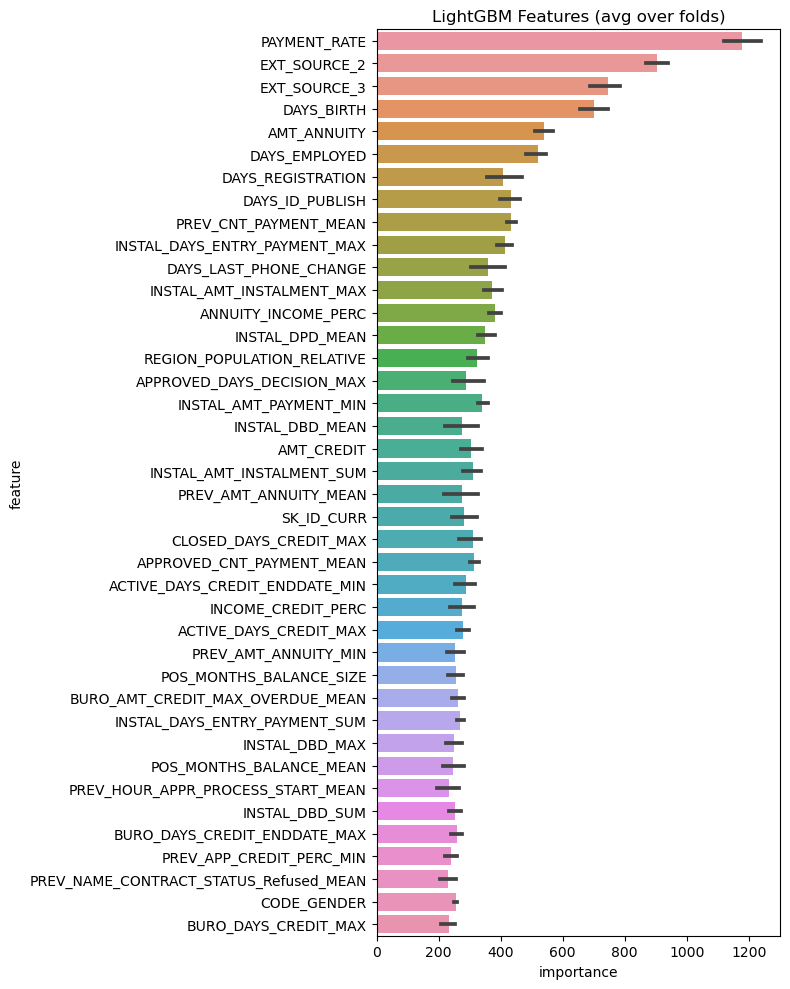

In [23]:
X = data[[c for c in data.columns if c != 'TARGET']]
y = data['TARGET']

target_0 = y[y==0].sample(40000).index
target_1 = y[y==1].index

sample = list(set(list(target_0)+list(target_1)))

X_sample = X.loc[sample]
X_scaled_sample = pd.DataFrame(StandardScaler().fit_transform(X_sample), index=X_sample.index, columns=X_sample.columns)

y_sample = y.loc[sample]

folds = KFold(n_splits=5, shuffle=True, random_state=1001)

oof_preds = np.zeros(X_scaled_sample.shape[0])
feature_importance_df = pd.DataFrame()

for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X_scaled_sample, y_sample)):
    train_x, train_y = X_scaled_sample.iloc[train_idx], y_sample.iloc[train_idx]
    valid_x, valid_y = X_scaled_sample.iloc[valid_idx], y_sample.iloc[valid_idx]

    # LightGBM parameters found by Bayesian optimization
    clf = LGBMClassifier(
        nthread=4,
        n_estimators=10000,
        learning_rate=0.02,
        num_leaves=34,
        colsample_bytree=0.9497036,
        subsample=0.8715623,
        max_depth=8,
        reg_alpha=0.041545473,
        reg_lambda=0.0735294,
        min_split_gain=0.0222415,
        min_child_weight=39.3259775)

    clf.fit(train_x.values, train_y.values, eval_set=[(train_x.values, train_y.values), (valid_x.values, valid_y.values)], eval_metric= 'auc', callbacks=[log_evaluation(), early_stopping(stopping_rounds=200)])

    oof_preds[valid_idx] = clf.predict_proba(valid_x.values, num_iteration=clf.best_iteration_)[:, 1]

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = X_scaled_sample.columns
    fold_importance_df["importance"] = clf.feature_importances_
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y.values, oof_preds[valid_idx])))
    del clf, train_x, train_y, valid_x, valid_y
    gc.collect()

print('Full AUC score %.6f' % roc_auc_score(y_sample, oof_preds))

cols = feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]
plt.figure(figsize=(8, 10))
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

best_features = feature_importance_df.groupby('feature').mean().sort_values(by='importance', ascending=False).head(50).index.values

In [24]:
data_filtered = data.copy()
data_filtered = data_filtered[best_features.tolist() + ['TARGET']]
data_filtered.shape

(307507, 51)

Je vais maintenant supprimer les **modalités correspondantes à des outliers**. Un peu plus de **27000 clients** ne seront **pas pris en compte dans la suite de l'étude** car ils seront considérés comme trop éloignés de la masse.

In [25]:
outlier_threshold = 5
minmax = MinMaxScaler()

index_outliers = []

for c in data_filtered.columns:
    if c not in ['SK_ID_CURR', 'TARGET'] and len(data_filtered[c].unique()) > 30:
        mask_outliers = np.abs(scipy_stats.zscore(data_filtered[c])) > outlier_threshold
        index_outliers.extend(data_filtered[c].loc[mask_outliers].index.values.tolist())

index_outliers = list(set(index_outliers))
print(f"Pourcentage des outliers avec TARGET = 1 : {100 * data['TARGET'].loc[index_outliers].sum() / len(index_outliers)}%")

index_without_outliers = [i for i in data_filtered.index if i not in index_outliers]

data_filtered = data_filtered.loc[index_without_outliers]

Pourcentage des outliers avec TARGET = 1 : 7.0499118761015485%


In [26]:
# Je sauvegarde ici les données nettoyées, filtrées, imputées et préparées pour la 
# suite du projet ! De la modélisation à la visualisation via le dashboard
save(data_filtered, 'data_filtered', filepath='./data')

# 3. Ultime préparation avant modélisation

Dans le cadre du travail de modélisation, il est obligatoire de séparer les données en un **jeu d'entraînement** et un **jeu de test**. J'ai donc séparé les données avec **80% pour le jeu d'entrainement**. Comme les données dont je dispose sont très déséquilibrées, j'ai veillé à ce que la **proportion des classes à prédire soit la même** dans les 2 jeux de données en réalisant une **stratification sur la feature cible `TARGET`**. 

In [28]:
data_filtered = load('data_filtered', filepath='./data')

In [29]:
data_final = data_filtered.copy()

In [32]:
X = data_final[[c for c in data_final.columns if c not in ['TARGET', 'SK_ID_CURR']]]
y = data_final['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=True, stratify=y, random_state=42)

In [33]:
y_train.value_counts(normalize=True)

0.0    0.918299
1.0    0.081701
Name: TARGET, dtype: float64

In [34]:
y_test.value_counts(normalize=True)

0.0    0.918299
1.0    0.081701
Name: TARGET, dtype: float64

Je vais **normaliser les données** avec un `StandardScaler` avant de réaliser, lorsque cela est nécessaire, un **rééchantillonage** avec la méthode **SMOTE** (**S**ynthetic **M**inority **O**versampling **TE**chnique) pour augmenter le nombre de données disponibles. Ces différentes transformations seront utilisées via un pipeline des librairies `sklearn` ou `imblearn`. Les données de test et de validation (dans le GridSearch) ne doivent **en aucun cas être rééchantillonnées** car il est essentiel que ces données soient le plus proche possible des données réelles futures.

In [35]:
def get_pipeline(classification_model, is_smote=True):
    
    if is_smote:
        pipeline = ImbPipeline([
            ('scaling', StandardScaler()),
            ('sampling', SMOTE(n_jobs=-1, random_state=42)),
            ('classification', classification_model)
        ])
    else:
        pipeline = SkPipeline([
            ('scaling', StandardScaler()),
            ('classification', classification_model)
        ])
        
    return pipeline

# 4. Quelles métriques utiliser ?

Dans cette partie, je vais définir les différents **métriques et indicateurs** sur lesquels je vais baser l'évaluation des modèles testés. C'est ici aussi que je vais notament définir la **fonction coût métier**. Cette fonction devra permettre d'optimiser le bénéfice de la banque.

Je vais maintenant chercher à calculer le score correspondant au résultat de la fonction coût que j'ai imaginée. Cette fonction devrait en théorie être **paramétrée en relation avec les besoins et les attentes de la société financière**.

La fonction coût est basée sur le calcul des indicateurs présents dans une matrice de confusion : les vrais négatifs (TN), les faux positifs (FP), les faux négatifs (FN) et les vrais positifs (TP).

Dans le cas étudié ici, il est utile de donner une **définition métier** à ces indicateurs pour mieux comprendre les résultats et travailler à l'élaboration de notre fonction coût !

* **TN** = Le client *peut rembourser* et la banque *accepte le prêt* (aucun problème dans ce cas)
* **FP** = Le client *peut rembourser* et la banque *n'accepte pas le prêt* (opportunité manquée)
* **FN** = Le client *ne peut pas rembourser* et la banque *accepte le prêt* (grosse erreur)
* **TP** = Le client *ne peut pas rembourser* et la banque *n'accepte pas le prêt* (aucun problème dans ce cas)

La clé du fonctionnement de la fonction coût est de **donner un certain poids à chacun de ces indicateurs** en fonction des attentes de la société financière. Tout dépend si la société "Prêt à dépenser" est plus encline à favoriser l'octroi ou le refus d'un prêt. 

Dans ce cas précis, j'ai fait l'hypothèse que **les faux négatifs étaient beaucoup plus coûteux pour la société que les faux positifs**. J'ai également choisi de **pénaliser tout de même légèrement les faux positifs** puisqu'ils représentent une perte de revenus pour la société. Pour finir, j'ai également décidé de **donner un poids plus important aux vrais positifs par rapport aux vrais négatifs** car même si les deux ne présentent aucun problème, je préfère **mettre en avant une prédiction qui aurait été plus dommageable pour la société si elle avait été mauvaise**.

Avec ces hypothèses, je peux définir un score que j'ai choisi de **normaliser** pour plus de lisibilité. Pour normaliser, je vais chercher à calculer l'**amplitude maximale** entre le *gain le plus important* que pourrait faire la société financière et la *perte maximale* qui pourrait survenir.

* Le gain maximal que pourrait faire la société surviendrait dans le cas suivant : Le prêt est **accordé à tous les clients qui remboursent** et **refusé aux clients qui ne remboursent pas**. Il s'agit bien évidemment du **meilleur cas possible** !

* La perte maximale pour la société correspondrait au cas suivant : Le prêt est **accordé à tous les clients qui ne remboursent pas** et **refusé aux clients qui peuvent rembourser**. Il s'agit bien évidemment du **pire cas possible** !

La fonction ci-dessous **renvoie donc le score normalisé** calculé à partir des classes réelles et celles prédites par le modèle choisi.

In [36]:
def cost_function_score(y_true, y_pred):
    (tn, fp, fn, tp) = confusion_matrix(y_true, y_pred).ravel()
    
    tn_gain = 1
    fp_perte = -2
    fn_perte = -20
    tp_gain = 2
        
    score = (tn * tn_gain + tp * tp_gain) + (fn * fn_perte + fp * fp_perte)
    gain_maximal = ((tn + fp) * tn_gain + (fn + tp) * tp_gain) 
    perte_maximale = ((tp + fn) * fn_perte + (tn + fp) * fp_perte)
    
    norm_score = (score - perte_maximale) / (gain_maximal - perte_maximale)
    
    return norm_score

Ci-dessous, j'ai également créé quelques **fonctions** très utiles pour la suite de l'étape de modélisation.

>La fonction `get_metrics` permet de calculer **différentes métriques** en fonction des données réelles et des résultats fournis par un modèle en termes de prediction et de probabilité.

>La fonction `get_confusion_matrix` permet d'afficher la **matrice de confusion** et de visualiser ainsi facilement les indicateurs utilisés pour calculer la fonction coût.

>La fonction `get_roc_curve` permet d'afficher la **courbe ROC** correspondant dans le cas du projet :
>* à la proportion de **clients ne pouvant pas rembourser dont la banque n'accepte pas le prêt**, 
>* en fonction de la proportion de **clients pouvant rembourser dont la banque n'accepte pas le prêt**.
>**Vrais positifs en ordonnée et Faux positifs en abscisse*.

>La fonction `get_precision_recall_curve` permet d'afficher la **courbe Precision/Recall** correspondant dans le cas du projet :
>* à la proportion de **clients ne pouvant pas rembourser** parmi tous les **clients dont la banque n'accepte pas le prêt**,
>* en fonction de la proportion de **clients ne pouvant pas rembourser et dont la banque n'accepte pas le prêt** parmi tous les **clients ne pouvant pas rembourser quelle que soit la décision de la banque**. 
>**Precision en ordonnée et Recall en abscisse*.

In [37]:
def get_metrics(y_true, y_predict, y_probability, name, data=None,
                scores=['bal_accuracy','recall_score','precision_score', 'f1_score', 'f2_score', 'f5_score', 'roc_auc_score','cost_function_score']):
       
    score_functions = {'bal_accuracy': (balanced_accuracy_score,{'y_true': y_true, 'y_pred': y_predict}),
                       'recall_score': (recall_score, {'y_true': y_true, 'y_pred': y_predict}),
                       'precision_score': (precision_score, {'y_true': y_true, 'y_pred': y_predict}),
                       'f1_score': (f1_score, {'y_true': y_true, 'y_pred': y_predict}),
                       'f2_score': (fbeta_score, {'y_true': y_true, 'y_pred': y_predict, 'beta': 2}),
                       'f5_score': (fbeta_score, {'y_true': y_true, 'y_pred': y_predict, 'beta': 5}),
                       'roc_auc_score':  (roc_auc_score, {'y_true': y_true, 'y_score': y_probability}),
                       'cost_function_score' : (cost_function_score, {'y_true': y_true, 'y_pred': y_predict})}
                 
    data = pd.DataFrame() if data is None else data
    data[name] = pd.Series([score_functions[score][0](**score_functions[score][1]) for score in scores], index=scores)
    
    return data

def get_confusion_matrix(y_true, y_predict, norm=True, cmap='Blues'):

    fig, ax = plt.subplots(figsize=(5,5))
   
    if norm:
        ConfusionMatrixDisplay.from_predictions(y_true, y_predict, normalize='true', cmap=cmap, ax=ax)
        ax.set_title('Matrice de confusion (Fréquences)')
    else:
        ConfusionMatrixDisplay.from_predictions(y_true, y_predict, cmap=cmap, ax=ax)
        ax.set_title('Matrice de confusion (Nombres)')

    ax.set_xlabel('Classe prédite')
    ax.set_ylabel('Classe réelle')
    ax.grid(False)
    plt.tight_layout(h_pad=0.2, w_pad=0.2)
    
def get_roc_curve(model, X_test, y_test):
    fig, ax = plt.subplots(figsize=(5,5))
    
    ax.plot([0, 1], [0, 1], color='k', ls='--', label='Pire résultat')
    RocCurveDisplay.from_estimator(model, X_test, y_test, name='Courbe ROC (Données de test)', c='b', ax=ax)
    ax.set_xlabel("Taux de clients pouvant rembourser dont\nla banque n'accepte pas le prêt.\n(Faux positif)")
    ax.set_ylabel("Taux de clients ne pouvant pas rembourser dont\nla banque n'accepte pas le prêt.\n(Vrai positif)")

def get_precision_recall_curve(model, X_test, y_test): 

    fig, ax = plt.subplots(figsize=(5,5))
    
    PrecisionRecallDisplay.from_estimator(model, X_test, y_test, name='Courbe Precision/Recall (Données de test)', c='b', ax=ax)
    ax.set_xlabel("Proportion de clients ne pouvant pas rembourser et dont la banque n'accepte pas le prêt parmis\ntous les clients ne pouvant pas rembourser quelle que soit la décision de la banque.\n(Recall = TP/(TP+FN))")
    ax.set_ylabel("Proportion de clients ne pouvant pas rembourser parmis\ntous les clients dont la banque n'accepte pas le prêt.\n(Precision = TP/(TP+FP))")

Je vais maintenant ci-dessous tester les différents indicateurs et métriques sur des **cas particuliers** que j'ai créé moi-même et qui représentent **différentes situations possibles**.

Grâce à ces différents scénarios, j'ai pu montrer que ma fonction coût est **particulièrement liée aux différents f_scores et au recall**. C'est parfaitement logique puisque j'ai choisi de **beaucoup pénaliser les faux négatifs** !

Dans la suite de l'étude, on entrainera donc les différents modèles en cherchant à optimiser le **recall**, le **f1_score**, le  **f2_score**, le **roc_auc_score** (plutôt adapté dans le cas de données déséquilibrées) et le **cost_function_score**. En intégrant ainsi ma fonction coût à l'optimisation du modèle, je réalise ce que l'on appelle du **"Cost-sensitive learning"** qui est très utilisé dans le milieu bancaire lorsque le modèle de score est directement développé par la société !

La méthode d'optimisation utilisée est donc un **mélange de multi-scoring avec du cost-sensitive learning** puisque l'on va utiliser la fonction coût et le roc_auc_score pendant l'entraînement des différents modèles. On calculera ensuite le **seuil de tolérance optimal** permettant de maximiser la fonction coût et ainsi le profit de la banque !

In [38]:
y_true = [0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1]
y_pred = [0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1]
scores = get_metrics(y_true, y_pred, y_pred, 'Parfait')

y_true = [0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1]
y_pred = [0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,1,1,1,1,1]
scores = get_metrics(y_true, y_pred, y_pred, 'Équilibre', scores)

y_true = [0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1]
y_pred = [0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1]
scores = get_metrics(y_true, y_pred, y_pred, 'Quelques prêts accordés non-remboursés', scores)

y_true = [0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1]
y_pred = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1]
scores = get_metrics(y_true, y_pred, y_pred, 'Beaucoup de prêts accordés non-remboursés', scores)

y_true = [0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1]
y_pred = [0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1]
scores = get_metrics(y_true, y_pred, y_pred, 'Quelques prêts non accordés remboursables', scores)

y_true = [0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1]
y_pred = [0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]
scores = get_metrics(y_true, y_pred, y_pred, 'Beaucoup de prêts non accordés remboursables', scores)

scores.T.sort_values(by='cost_function_score')

,bal_accuracy,recall_score,precision_score,f1_score,f2_score,f5_score,roc_auc_score,cost_function_score
Beaucoup de prêts accordés non-remboursés,0.6,0.2,1.000000,0.333333,0.238095,0.206349,0.6,0.296
Équilibre,0.5,0.5,0.500000,0.500000,0.500000,0.500000,0.5,0.500
Quelques prêts accordés non-remboursés,0.9,0.8,1.000000,0.888889,0.833333,0.806202,0.9,0.824
Beaucoup de prêts non accordés remboursables,0.6,1.0,0.555556,0.714286,0.862069,0.970149,0.6,0.904
Quelques prêts non accordés remboursables,0.9,1.0,0.833333,0.909091,0.961538,0.992366,0.9,0.976
Parfait,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1.0,1.000


In [39]:
scores.T.corr().loc[['cost_function_score']]

,bal_accuracy,recall_score,precision_score,f1_score,f2_score,f5_score,roc_auc_score,cost_function_score
cost_function_score,0.722929,0.990736,0.056724,0.948231,0.996827,0.994336,0.722929,1.0


In [40]:
cost_scorer = make_scorer(cost_function_score, greater_is_better=True)
f2_scorer = make_scorer(fbeta_score, greater_is_better=True, beta=2)
recall_scorer = make_scorer(recall_score, greater_is_better=True)
f1_scorer = make_scorer(f1_score, greater_is_better=True)

scorers = {
    'roc_auc': 'roc_auc',
    'cost_scorer': cost_scorer,
    'recall_scorer': recall_scorer,
    'f1_scorer': f1_scorer,
    'f2_scorer': f2_scorer
}